# RQ2 Analysis (scalability of CRUD operations)

## Graph Types

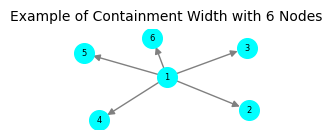

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.DiGraph()
G.add_nodes_from([1, 2, 3, 4, 5, 6]) 
G.add_edges_from([(1, 2), (1, 3), (1, 4), (1, 5), (1, 6)])
pos = nx.spring_layout(G) 
plt.figure(figsize=(2, 1)) 
nx.draw(G, pos=pos, with_labels=True, node_color='cyan', node_size=200,
        edge_color='gray', font_size=6, arrows=True, arrowstyle='-|>', arrowsize=10)
plt.title("Example of Containment Width with 6 Nodes", fontsize=10)
plt.axis('off')
plt.show()

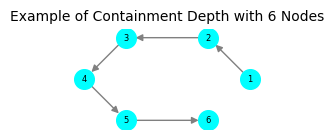

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
 
G = nx.DiGraph()
G.add_nodes_from([1, 2, 3, 4, 5, 6]) 
G.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]) 
pos = nx.circular_layout(G) 
plt.figure(figsize=(2, 1)) 
nx.draw(G, pos=pos, with_labels=True, node_color='cyan', node_size=200,
        edge_color='gray', font_size=6, arrows=True, arrowstyle='-|>', arrowsize=10)
plt.title("Example of Containment Depth with 6 Nodes", fontsize=10)
plt.axis('off')
plt.show()

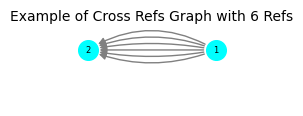

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.MultiDiGraph()
G.add_nodes_from([1, 2]) 
G.add_edges_from([(1, 2), (1, 2), (1, 2), (1, 2), (1, 2),(1, 2)])  
pos = nx.circular_layout(G)
plt.figure(figsize=(2, 1))
nx.draw_networkx_nodes(G, pos, node_color='cyan', node_size=200)
nx.draw_networkx_labels(G, pos, font_size=6)
for i, edge in enumerate(G.edges(keys=True)):
    rad = 0.1 * (i - 2)   
    nx.draw_networkx_edges(G, pos, edgelist=[(edge[0], edge[1])],
                           connectionstyle=f'arc3,rad={rad}',
                           edge_color='gray', arrows=True, arrowstyle='-|>', arrowsize=10)
plt.title("Example of Cross Refs Graph with 6 Refs", fontsize=10)
plt.axis('off')
plt.show()

# Results

### Utils

In [4]:
def shorten_x_axis_labels(ax):
    def shorten_label(label):
        try:
            x = int(label)
            if x >= 1_000_000:
                return f'{x//1_000_000}M'
            elif x >= 1_000:
                return f'{x//1_000}k'
            else:
                return str(x)
        except ValueError:
            return label  # If label is not a number, return as is

    xticks_labels = [item.get_text() for item in ax.get_xticklabels()]
    short_labels = [shorten_label(lbl) for lbl in xticks_labels]
    ax.set_xticklabels(short_labels)


In [5]:
from matplotlib.ticker import FuncFormatter

def get_short_number_formatter():
    def shorten_large_number(x, pos):
        if x >= 1_000_000:
            return f'{int(x*1e-6)}M'
        elif x >= 1_000:
            return f'{int(x*1e-3)}k'
        else:
            return str(int(x))
    return FuncFormatter(shorten_large_number)


## Create Operations

#### Create Single

In [6]:
import pandas as pd
import glob

# Find all CreateSingle_run_*.csv files
create_run_files = glob.glob('../results/RQ2/CreateSingle/CreateSingle_run_*.csv')

# Load and concatenate all runs
create_runs = pd.concat([pd.read_csv(f) for f in create_run_files], ignore_index=True)

ordered_create_runs = create_runs.sort_values('time',ascending=False)

In [7]:
# Group by element count
group_col = 'element_count' 

grouped = create_runs.groupby(group_col).agg(
    avg_time=('time', 'mean'),
    min_time=('time', 'min'),
    max_time=('time', 'max'),
    avg_mem=('mem', 'mean'),
    min_mem=('mem', 'min'),
    max_mem=('mem', 'max'),
).reset_index()

grouped

,element_count,avg_time,min_time,max_time,avg_mem,min_mem,max_mem
0,10,10.200000,9,13,3543.266667,2933,4932
1,50,10.766667,9,13,3468.333333,2933,4935
2,100,11.066667,9,16,3494.666667,2933,4943
3,500,13.866667,12,18,3478.933333,2933,4943
4,1000,16.700000,14,48,3514.233333,2933,5105
5,5000,48.833333,41,68,9368.533333,9037,9928
6,10000,72.766667,62,89,19244.233333,17433,19947
7,50000,326.533333,290,452,85174.433333,84813,86016
8,100000,627.733333,565,883,165868.366667,164722,167428
9,500000,3090.933333,2794,4224,390090.100000,172677,505125


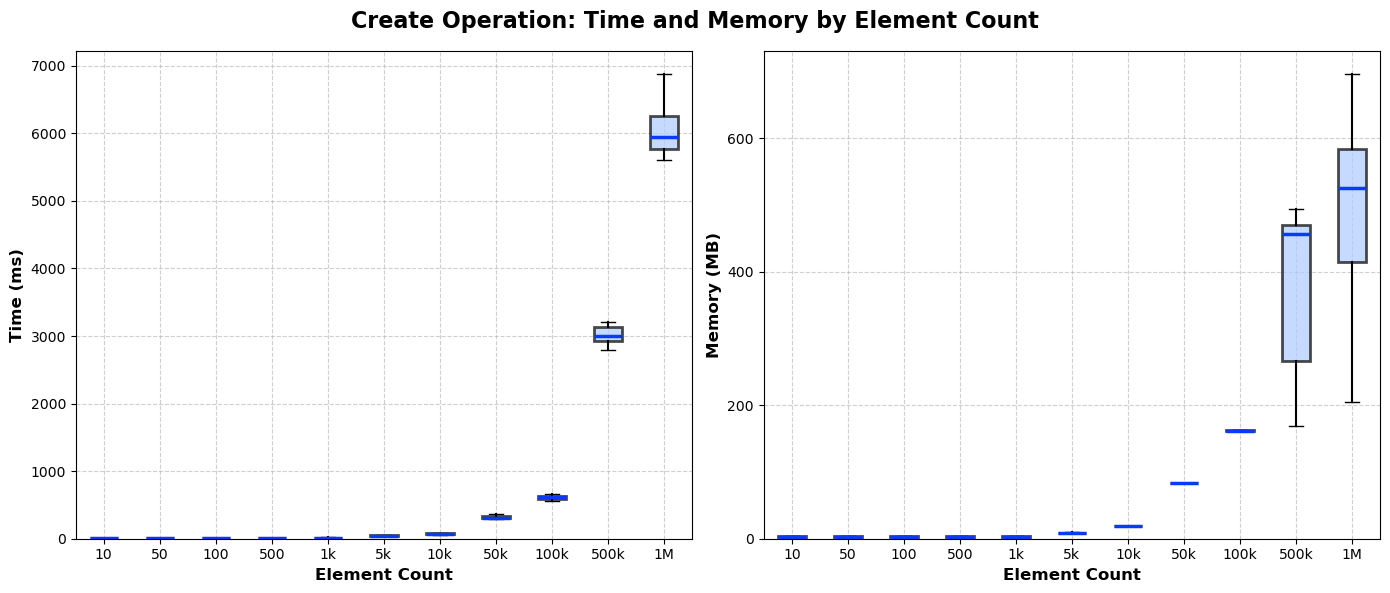

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
group_col = 'element_count'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))


create_runs.boxplot(column='time', by=group_col, ax=axes[0], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[0].set_title('')
axes[0].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Time (ms)', fontsize=12, fontweight='bold') 
axes[0].grid(True, linestyle='--', alpha=0.6)


create_runs.boxplot(column='mem', by=group_col, ax=axes[1], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[1].set_xlabel('Element Count', fontsize=12, fontweight='bold')
shorten_x_axis_labels(axes[0]) 
shorten_x_axis_labels(axes[1])
axes[1].yaxis.set_major_locator(mticker.MultipleLocator(200*1024))  # 200 MB steps in MB 
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x/1024)}")) 
axes[1].set_ylabel('Memory (MB)', fontsize=12, fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('')
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)
    
plt.suptitle('Create Operation: Time and Memory by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("img/rq2createSingle.pdf", format='pdf', bbox_inches='tight') 
plt.show()

#### Create Containment Width

In [9]:
import pandas as pd
import glob

# Find all CreateContainmentWidth_run_*.csv files
create_containment_run_files = glob.glob('../results/RQ2/CreateContainmentWidth/CreateContainmentWidth_run_*.csv')

# Load and concatenate all runs
create_containment_runs = pd.concat([pd.read_csv(f) for f in create_containment_run_files], ignore_index=True)

ordered_create_runs_containment = create_containment_runs.sort_values('time',ascending=False)
 

In [10]:
# Group by element count
group_col = 'element_count' 

grouped_containment = create_containment_runs.groupby(group_col).agg(
    avg_time=('time', 'mean'),
    min_time=('time', 'min'),
    max_time=('time', 'max'),
    avg_mem=('mem', 'mean'),
    min_mem=('mem', 'min'),
    max_mem=('mem', 'max'),
).reset_index()

grouped_containment

,element_count,avg_time,min_time,max_time,avg_mem,min_mem,max_mem
0,10,30.533333,18,281,4.065933e+03,3175,4646
1,50,24.366667,19,50,4.100433e+03,4098,4101
2,100,26.200000,19,136,4.100533e+03,4098,4101
3,500,36.933333,27,195,4.122067e+03,4098,4748
4,1000,40.166667,34,119,4.100367e+03,4098,4101
5,5000,139.100000,108,697,1.597480e+04,14338,16384
6,10000,197.533333,182,246,2.874033e+04,28672,30722
7,50000,761.333333,695,1170,1.335635e+05,133122,139739
8,100000,1421.833333,1306,2059,2.605032e+05,259938,262144
9,500000,6592.233333,6206,8106,5.490539e+05,301325,941945


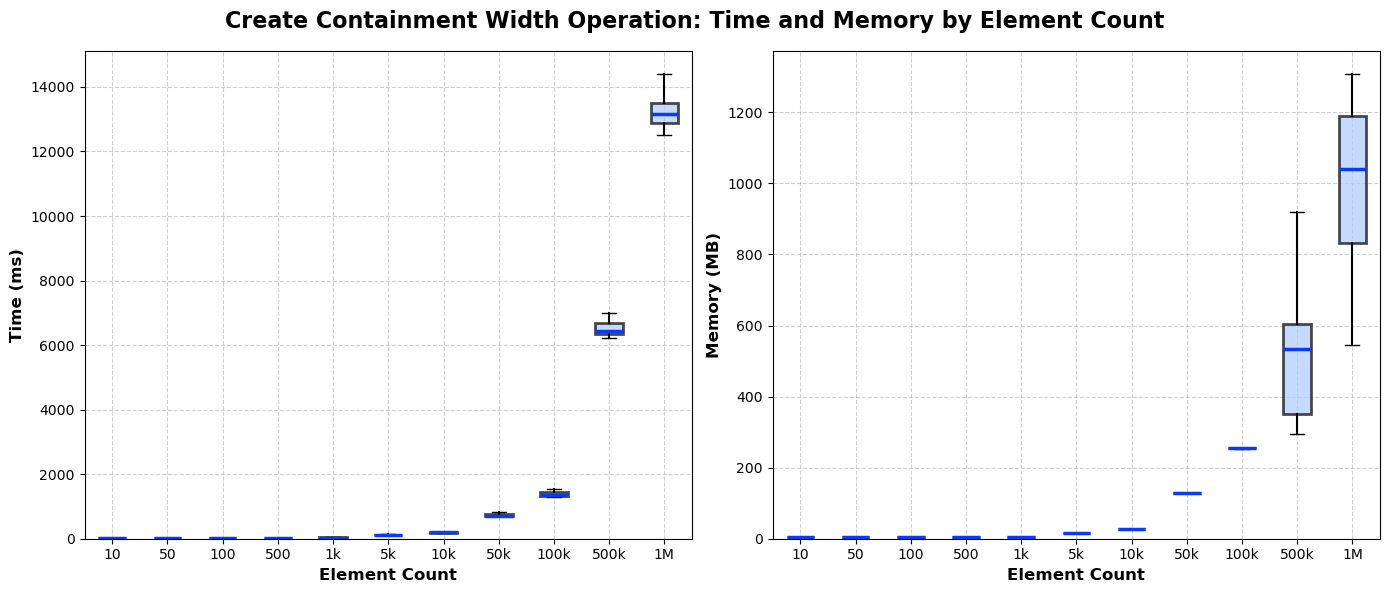

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

group_col = 'element_count'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))


create_containment_runs.boxplot(column='time', by=group_col, ax=axes[0], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[0].set_title('')
axes[0].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.6)


create_containment_runs.boxplot(column='mem', by=group_col, ax=axes[1], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[1].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[1].yaxis.set_major_locator(mticker.MultipleLocator(200*1024))  # 200 MB steps in MB 
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x/1024)}")) 
axes[1].set_ylabel('Memory (MB)', fontsize=12, fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('')
shorten_x_axis_labels(axes[0]) 
shorten_x_axis_labels(axes[1])
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)
plt.suptitle('Create Containment Width Operation: Time and Memory by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("img/rq2createCW.pdf", format='pdf', bbox_inches='tight') 
plt.show()

#### Create Containment Depth

In [12]:
import pandas as pd
import glob

# Find all CreateContainmentDepth_run_*.csv files
create_containment_d_run_files = glob.glob('../results/RQ2/CreateContainmentDepth/CreateContainmentDepth_run_*.csv')

# Load and concatenate all runs
create_containment_d_runs = pd.concat([pd.read_csv(f) for f in create_containment_d_run_files], ignore_index=True)

ordered_create_runs_containment = create_containment_d_runs.sort_values('time',ascending=False)

In [13]:
# Group by element count
group_col = 'element_count' 

grouped_containment_d = create_containment_d_runs.groupby(group_col).agg(
    avg_time=('time', 'mean'),
    min_time=('time', 'min'),
    max_time=('time', 'max'),
    avg_mem=('mem', 'mean'),
    min_mem=('mem', 'min'),
    max_mem=('mem', 'max'),
).reset_index()

grouped_containment_d

,element_count,avg_time,min_time,max_time,avg_mem,min_mem,max_mem
0,10,22.433333,17,87,3.901167e+03,2678,5706
1,50,20.100000,17,25,3.857667e+03,2830,5708
2,100,22.866667,18,46,3.936000e+03,2678,5705
3,500,32.233333,26,120,3.809867e+03,2678,5708
4,1000,41.300000,33,169,5.677500e+03,4096,8121
5,5000,107.400000,93,160,1.774853e+04,16384,20480
6,10000,205.500000,178,405,3.335087e+04,32747,34704
7,50000,675.033333,631,799,1.561794e+05,155147,157767
8,100000,1270.833333,1128,2662,3.079041e+05,306716,309681
9,500000,5735.033333,5278,8169,9.023990e+05,501092,1158985


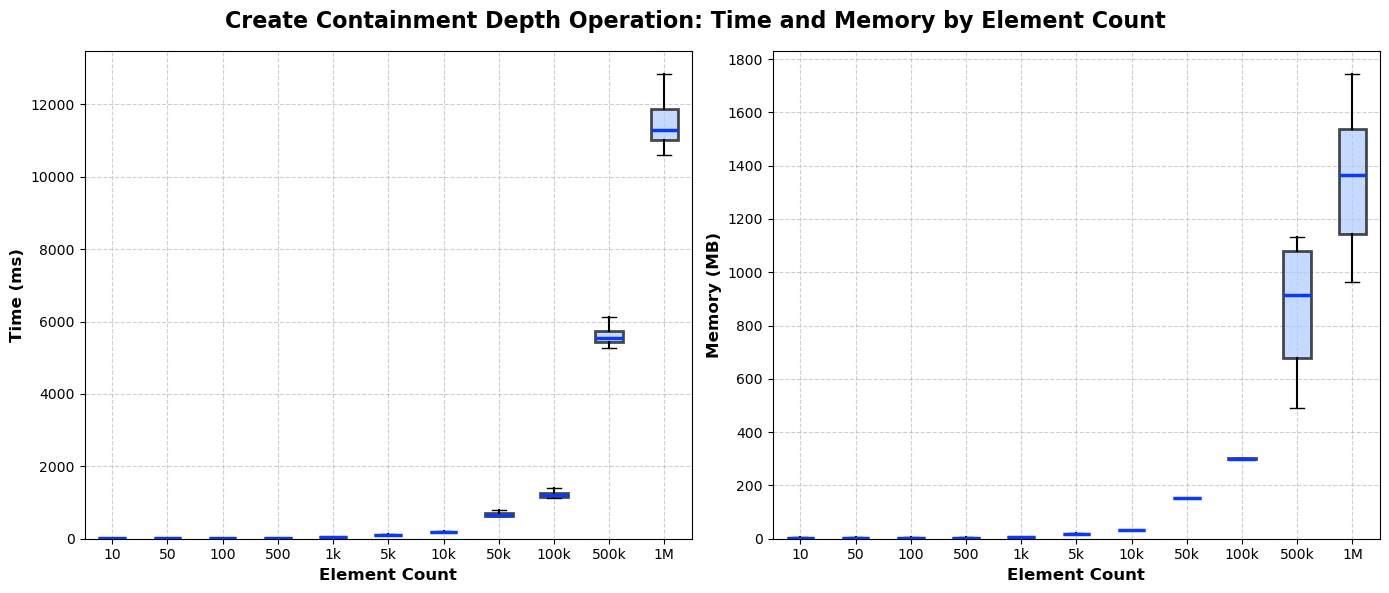

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
group_col = 'element_count'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))


create_containment_d_runs.boxplot(column='time', by=group_col, ax=axes[0], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[0].set_title('')
axes[0].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.6)


create_containment_d_runs.boxplot(column='mem', by=group_col, ax=axes[1], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[1].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[1].yaxis.set_major_locator(mticker.MultipleLocator(200*1024))  # 200 MB steps in MB 
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x/1024)}")) 
axes[1].set_ylabel('Memory (MB)', fontsize=12, fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('')
shorten_x_axis_labels(axes[0]) 
shorten_x_axis_labels(axes[1])
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)

plt.suptitle('Create Containment Depth Operation: Time and Memory by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("img/rq2createCD.pdf", format='pdf', bbox_inches='tight') 
plt.show()

#### Create Cross Ref

In [15]:
import pandas as pd
import glob

# Find all CreateContainmentWidth_run_*.csv files
create_cross_ref_run_files = glob.glob('../results/RQ2/CreateCrossRef/CreateCrossRef_run_*.csv')

# Load and concatenate all runs
create_cross_ref_run = pd.concat([pd.read_csv(f) for f in create_cross_ref_run_files], ignore_index=True)

ordered_create_cross_ref_run = create_cross_ref_run.sort_values('time',ascending=False)

In [16]:
# Group by element count
group_col = 'element_count' 

grouped_cross_ref = create_cross_ref_run.groupby(group_col).agg(
    avg_time=('time', 'mean'),
    min_time=('time', 'min'),
    max_time=('time', 'max'),
    avg_mem=('mem', 'mean'),
    min_mem=('mem', 'min'),
    max_mem=('mem', 'max'),
).reset_index()

grouped_cross_ref

,element_count,avg_time,min_time,max_time,avg_mem,min_mem,max_mem
0,10,60.233333,18,1061,3612.600000,2576,5552
1,50,43.600000,29,252,3634.900000,2571,5551
2,100,21.133333,18,32,3671.800000,2571,5553
3,500,45.600000,34,166,3764.866667,2571,5553
4,1000,34.200000,27,131,3717.233333,2615,5553
5,5000,76.266667,66,152,6979.433333,5133,8192
6,10000,133.066667,117,291,11268.833333,10011,13736
7,50000,644.633333,531,2032,49698.533333,49092,52023
8,100000,1316.100000,1063,4759,98333.833333,97045,101292
9,500000,5816.300000,5441,8522,256357.800000,112489,483328


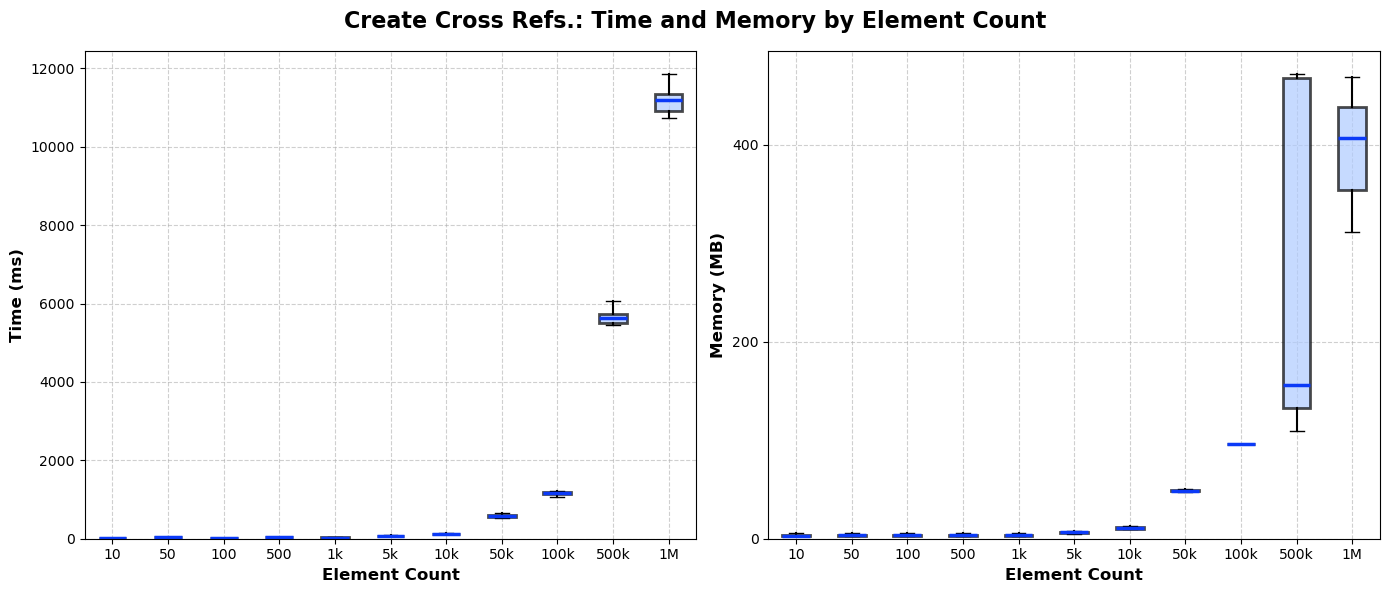

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

group_col = 'element_count'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))


create_cross_ref_run.boxplot(column='time', by=group_col, ax=axes[0], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[0].set_title('')
axes[0].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.6)


create_cross_ref_run.boxplot(column='mem', by=group_col, ax=axes[1], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[1].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[1].yaxis.set_major_locator(mticker.MultipleLocator(200*1024))  # 200 MB steps in MB 
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x/1024)}")) 
axes[1].set_ylabel('Memory (MB)', fontsize=12, fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('')
shorten_x_axis_labels(axes[0]) 
shorten_x_axis_labels(axes[1])
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)

plt.suptitle('Create Cross Refs.: Time and Memory by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("img/rq2createCrossRef.pdf", format='pdf', bbox_inches='tight') 
plt.show()

### Average

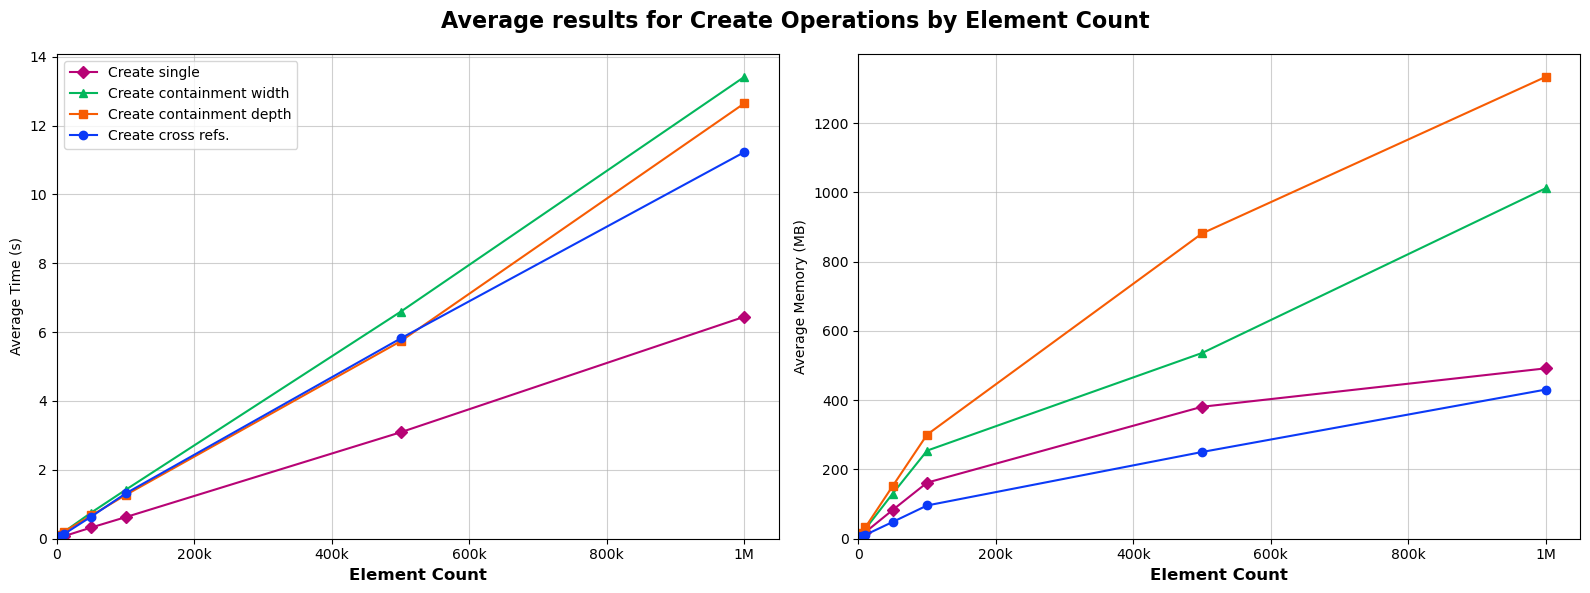

In [18]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


avg_r = create_cross_ref_run.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
avg_d = create_containment_d_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
avg_w = create_containment_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
avg_s = create_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()

# Convert units: time ms -> s, memory KB -> MB
for df in [avg_r, avg_d, avg_w, avg_s]:
    df['time'] = df['time'] / 1000       # ms to seconds
    df['mem'] = df['mem'] / 1024         # KB to MB

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Colors and markers for each dataset
datasets = [
    (avg_s, '#B70375', 'D', 'Create single'),
    (avg_w, '#03B75C', '^', 'Create containment width'),
    (avg_d, '#F75C03', 's', 'Create containment depth'),
    (avg_r, '#0B3AF7', 'o', 'Create cross refs.'),
]

# Plot average time
for df, color, marker, label in datasets:
    axes[0].plot(df['element_count'], df['time'], marker=marker, linestyle='-', color=color, label=label)
axes[0].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Average Time (s)')
axes[0].grid(True, alpha=0.6)
axes[0].xaxis.set_major_formatter(get_short_number_formatter())
axes[0].legend()

# Plot average memory
for df, color, marker, label in datasets:
    axes[1].plot(df['element_count'], df['mem'], marker=marker, linestyle='-', color=color, label=label)
axes[1].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Memory (MB)')
axes[1].grid(True, alpha=0.6)
axes[1].xaxis.set_major_formatter(get_short_number_formatter()) 
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)
axes[0].set_xlim(left=0)
axes[1].set_xlim(left=0)

plt.suptitle('Average results for Create Operations by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("img/rq2avgCreate.pdf", format='pdf', bbox_inches='tight') 
plt.show()


## Read Operations

### Read Single

In [19]:
import pandas as pd
import glob

 
read_run_files = glob.glob('../results/RQ2/ReadSingle/ReadSingle_run_*.csv')

# Load and concatenate all runs
read_runs = pd.concat([pd.read_csv(f) for f in read_run_files], ignore_index=True)

ordered_read_runs = read_runs.sort_values('time',ascending=False)

In [20]:
# Group by element count
group_col = 'element_count' 

grouped_read = read_runs.groupby(group_col).agg(
    avg_time=('time', 'mean'),
    min_time=('time', 'min'),
    max_time=('time', 'max'),
    avg_mem=('mem', 'mean'),
    min_mem=('mem', 'min'),
    max_mem=('mem', 'max'),
).reset_index()

grouped_read

,element_count,avg_time,min_time,max_time,avg_mem,min_mem,max_mem
0,10,48.366667,36,82,4098.000000,4098,4098
1,50,2.166667,1,6,4097.733333,4096,4098
2,100,2.233333,1,5,4097.933333,4096,4098
3,500,2.033333,1,3,4097.933333,4096,4098
4,1000,2.266667,1,4,4097.933333,4096,4098
5,5000,2.266667,1,4,4097.933333,4096,4098
6,10000,2.166667,0,4,4098.000000,4098,4098
7,50000,2.300000,1,6,4097.933333,4096,4098
8,100000,2.433333,1,4,4098.000000,4098,4098
9,500000,2.166667,1,3,4098.000000,4098,4098


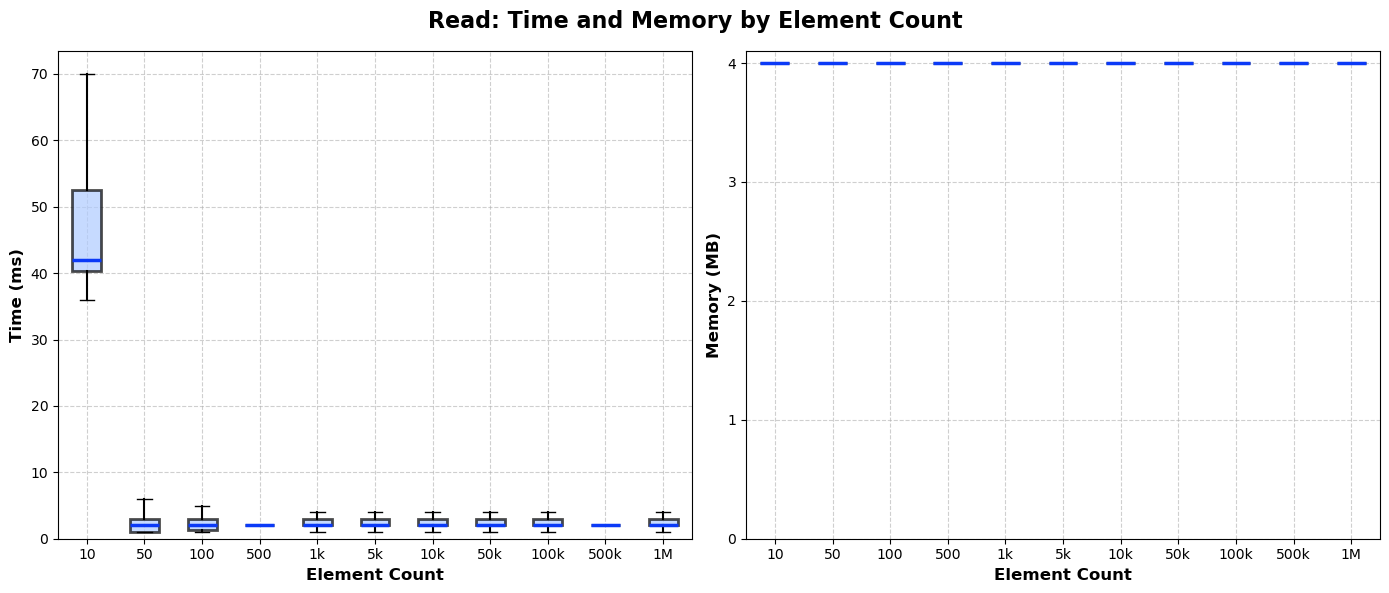

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

group_col = 'element_count'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))


read_runs.boxplot(column='time', by=group_col, ax=axes[0], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[0].set_title('')
axes[0].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.6)


read_runs.boxplot(column='mem', by=group_col, ax=axes[1], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[1].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[1].yaxis.set_major_locator(mticker.MultipleLocator(1*1024))  # 1 MB steps in MB 
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x/1024)}")) 
axes[1].set_ylabel('Memory (MB)', fontsize=12, fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('')
shorten_x_axis_labels(axes[0]) 
shorten_x_axis_labels(axes[1])
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)
axes[1].set_ylim(top=4200)
plt.suptitle('Read: Time and Memory by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("img/rq2readSingle.pdf", format='pdf', bbox_inches='tight') 
plt.show()

### Read Containment Width

In [22]:
import pandas as pd
import glob

 
read_c_w_run_files = glob.glob('../results/RQ2/ReadContainmentWidth/ReadContainmentWidth_run_*.csv')

# Load and concatenate all runs
read_c_w_runs = pd.concat([pd.read_csv(f) for f in read_c_w_run_files], ignore_index=True)

ordered_read_c_w_runs = read_c_w_runs.sort_values('time',ascending=False)

In [23]:
# Group by element count
group_col = 'element_count' 

grouped_read_c_w_runs = read_c_w_runs.groupby(group_col).agg(
    avg_time=('time', 'mean'),
    min_time=('time', 'min'),
    max_time=('time', 'max'),
    avg_mem=('mem', 'mean'),
    min_mem=('mem', 'min'),
    max_mem=('mem', 'max'),
).reset_index()

grouped_read_c_w_runs

,element_count,avg_time,min_time,max_time,avg_mem,min_mem,max_mem
0,10,57.300000,35,374,3450.033333,2261,4737
1,50,2.733333,1,4,3501.200000,2260,4730
2,100,2.900000,2,5,3450.066667,2260,4730
3,500,7.966667,3,85,3457.033333,2276,4730
4,1000,6.033333,5,8,3517.733333,2486,4857
5,5000,18.533333,16,27,7855.166667,7011,8817
6,10000,34.800000,30,82,15714.300000,14704,16384
7,50000,149.733333,135,223,61225.166667,60297,63490
8,100000,314.066667,282,620,135559.300000,134570,138367
9,500000,1565.133333,1451,1914,377864.900000,351955,404969


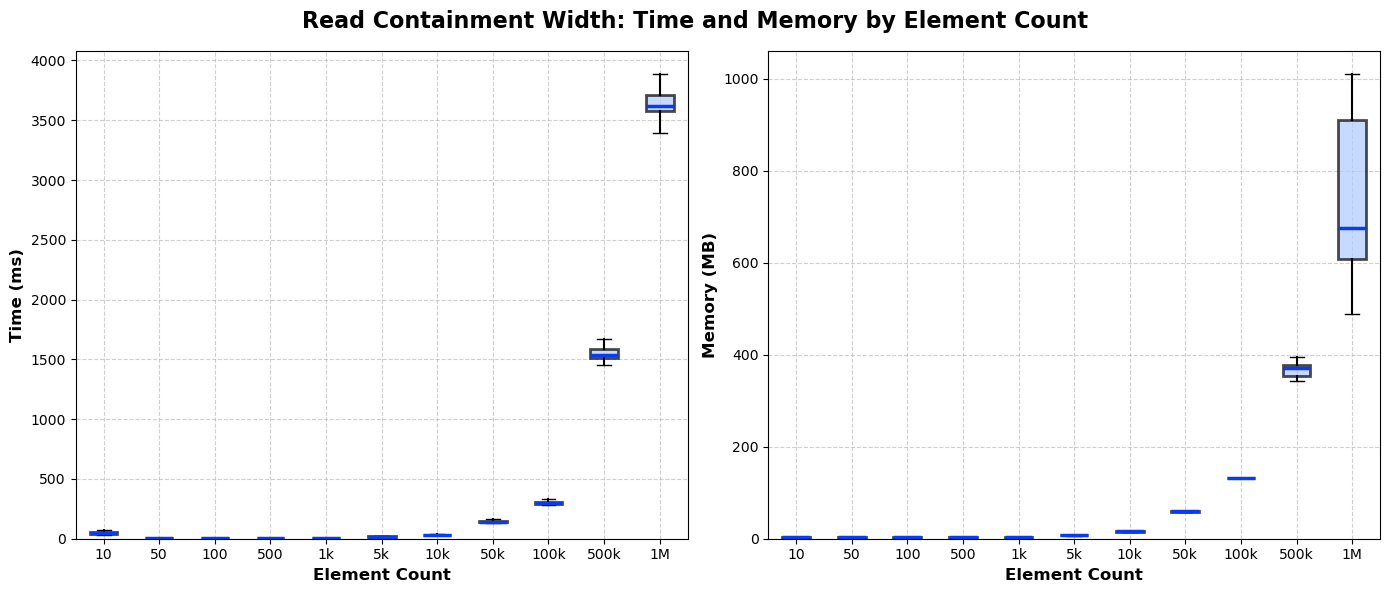

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
group_col = 'element_count'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))


read_c_w_runs.boxplot(column='time', by=group_col, ax=axes[0], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[0].set_title('')
axes[0].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.6)


read_c_w_runs.boxplot(column='mem', by=group_col, ax=axes[1], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[1].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[1].yaxis.set_major_locator(mticker.MultipleLocator(200*1024))  # 200 MB steps in MB 
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x/1024)}")) 
axes[1].set_ylabel('Memory (MB)', fontsize=12, fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('')
shorten_x_axis_labels(axes[0]) 
shorten_x_axis_labels(axes[1])
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)

plt.suptitle('Read Containment Width: Time and Memory by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("img/rq2readCW.pdf", format='pdf', bbox_inches='tight') 
plt.show()

### Read Containment Depth

In [25]:
import pandas as pd
import glob

 
read_c_d_run_files = glob.glob('../results/RQ2/ReadContainmentDepth/ReadContainmentDepth_run_*.csv')

# Load and concatenate all runs
read_c_d_runs = pd.concat([pd.read_csv(f) for f in read_c_d_run_files], ignore_index=True)

ordered_read_c_d_runs = read_c_d_runs.sort_values('time',ascending=False)

In [26]:
# Group by element count
group_col = 'element_count' 

grouped_read_c_w_runs = read_c_w_runs.groupby(group_col).agg(
    avg_time=('time', 'mean'),
    min_time=('time', 'min'),
    max_time=('time', 'max'),
    avg_mem=('mem', 'mean'),
    min_mem=('mem', 'min'),
    max_mem=('mem', 'max'),
).reset_index()

grouped_read_c_w_runs

,element_count,avg_time,min_time,max_time,avg_mem,min_mem,max_mem
0,10,57.300000,35,374,3450.033333,2261,4737
1,50,2.733333,1,4,3501.200000,2260,4730
2,100,2.900000,2,5,3450.066667,2260,4730
3,500,7.966667,3,85,3457.033333,2276,4730
4,1000,6.033333,5,8,3517.733333,2486,4857
5,5000,18.533333,16,27,7855.166667,7011,8817
6,10000,34.800000,30,82,15714.300000,14704,16384
7,50000,149.733333,135,223,61225.166667,60297,63490
8,100000,314.066667,282,620,135559.300000,134570,138367
9,500000,1565.133333,1451,1914,377864.900000,351955,404969


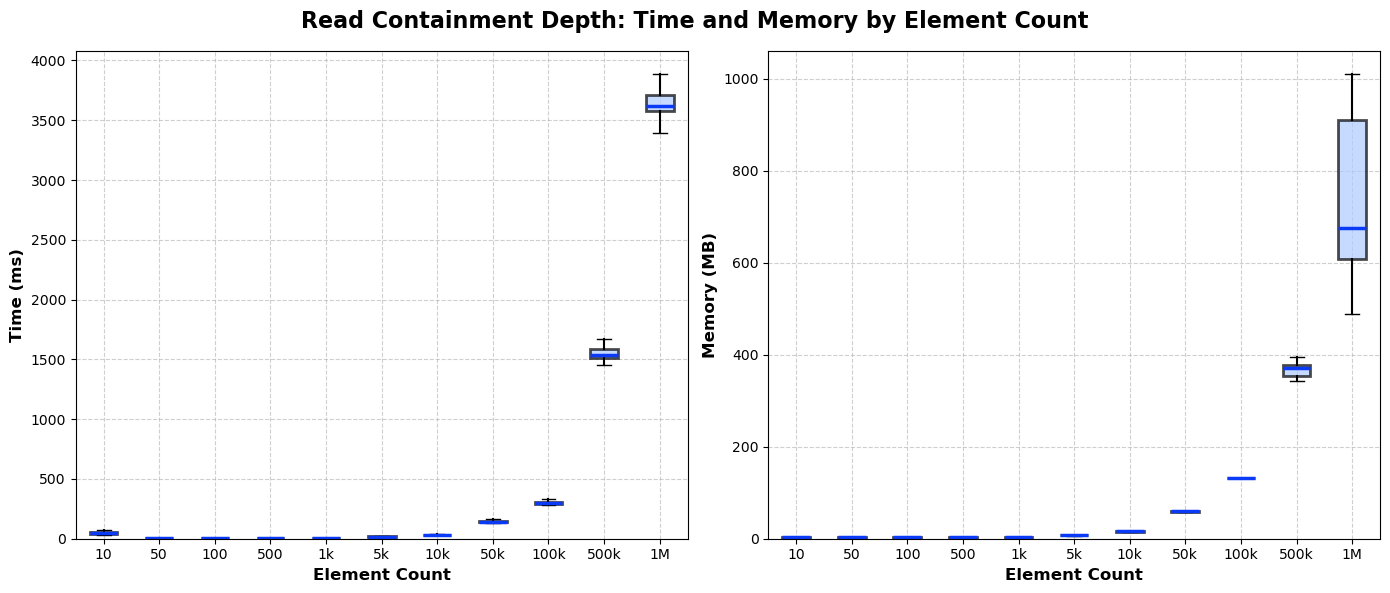

In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


group_col = 'element_count'
fig, axes = plt.subplots(1, 2, figsize=(14, 6))


read_c_w_runs.boxplot(column='time', by=group_col, ax=axes[0], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[0].set_title('')
axes[0].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.6) 
 
read_c_w_runs.boxplot(column='mem', by=group_col, ax=axes[1], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[1].set_xlabel('Element Count', fontsize=12, fontweight='bold')
# Change ticks to MB since csv is store in KB
axes[1].yaxis.set_major_locator(mticker.MultipleLocator(200*1024))  # 200 MB steps in MB
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x/1024)}"))
axes[1].set_ylabel('Memory (MB)', fontsize=12, fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('') 
shorten_x_axis_labels(axes[0]) 
shorten_x_axis_labels(axes[1])
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)

plt.suptitle('Read Containment Depth: Time and Memory by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("img/rq2readCD.pdf", format='pdf', bbox_inches='tight') 
plt.show()


### Read Cross Ref

In [28]:
import pandas as pd
import glob

 
read_cross_ref_run_files = glob.glob('../results/RQ2/ReadCrossRef/ReadCrossRef_run_*.csv')

# Load and concatenate all runs
read_cross_ref_runs = pd.concat([pd.read_csv(f) for f in read_cross_ref_run_files], ignore_index=True)

ordered_read_cross_ref_runs = read_cross_ref_runs.sort_values('time',ascending=False)

In [29]:
# Group by element count
group_col = 'element_count' 

grouped_read_cross_ref_runs = read_cross_ref_runs.groupby(group_col).agg(
    avg_time=('time', 'mean'),
    min_time=('time', 'min'),
    max_time=('time', 'max'),
    avg_mem=('mem', 'mean'),
    min_mem=('mem', 'min'),
    max_mem=('mem', 'max'),
).reset_index()

grouped_read_cross_ref_runs

,element_count,avg_time,min_time,max_time,avg_mem,min_mem,max_mem
0,10,379.766667,265,3249,3452.100000,2558,4098
1,50,218.500000,177,720,3453.233333,2558,4098
2,100,180.533333,169,267,3495.933333,2558,4098
3,500,179.000000,155,262,3453.166667,2558,4098
4,1000,177.733333,153,216,3549.100000,2558,4098
5,5000,178.000000,155,221,3453.333333,2558,4098
6,10000,178.233333,157,219,3514.133333,2713,4098
7,50000,179.100000,172,248,3452.633333,2558,4098
8,100000,175.633333,153,193,3492.500000,2556,4098
9,500000,176.000000,158,189,3454.333333,2558,4098


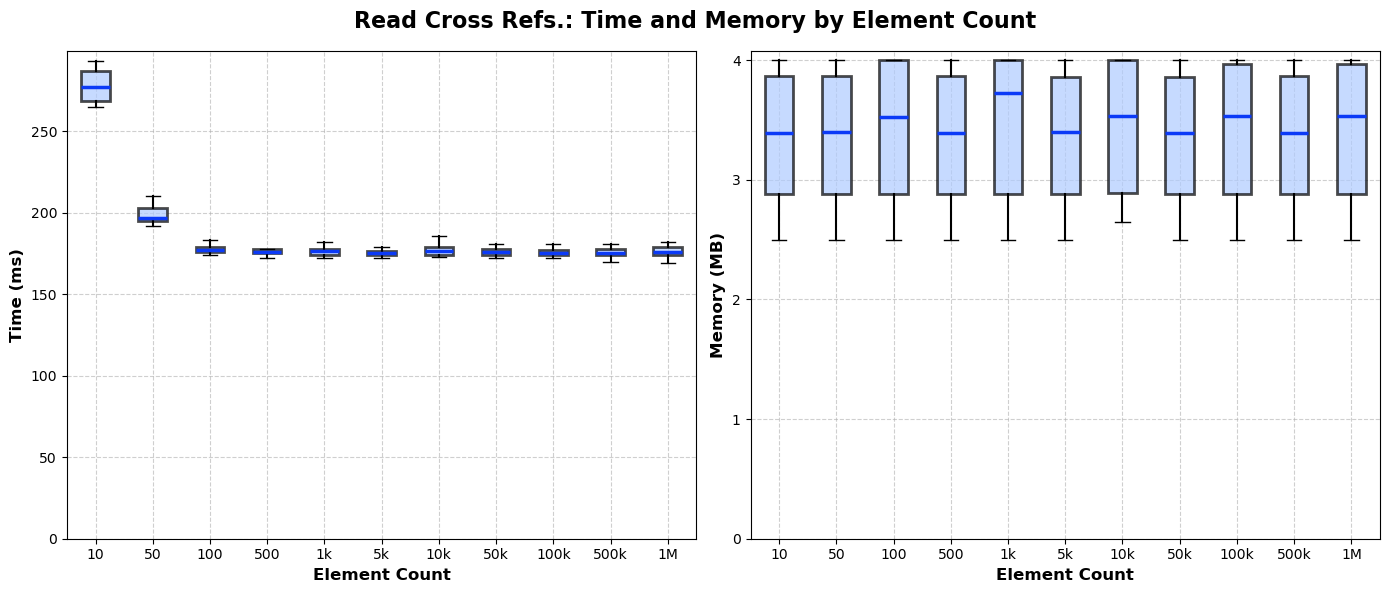

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

group_col = 'element_count'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))


read_cross_ref_runs.boxplot(column='time', by=group_col, ax=axes[0], patch_artist=True,showfliers=False,
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[0].set_title('')
axes[0].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.6)


read_cross_ref_runs.boxplot(column='mem', by=group_col, ax=axes[1], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[1].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[1].yaxis.set_major_locator(mticker.MultipleLocator(1*1024))  # 1 MB steps in MB 
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x/1024)}")) 
axes[1].set_ylabel('Memory (MB)', fontsize=12, fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('')
shorten_x_axis_labels(axes[0]) 
shorten_x_axis_labels(axes[1])
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)

plt.suptitle('Read Cross Refs.: Time and Memory by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("img/rq2readCrossRef.pdf", format='pdf', bbox_inches='tight') 
plt.show()

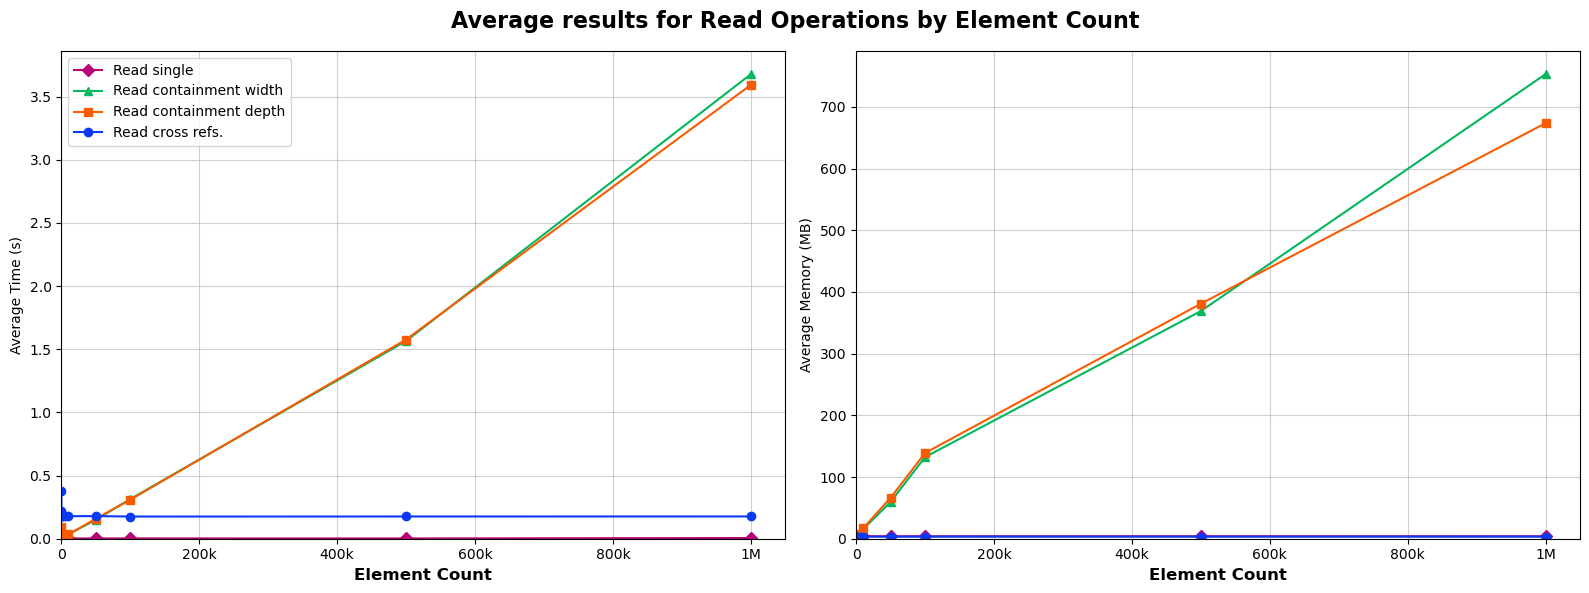

In [31]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


avg_r = read_cross_ref_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
avg_d = read_c_d_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
avg_w = read_c_w_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
avg_s = read_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()

# Convert units: time ms -> s, memory KB -> MB
for df in [avg_r, avg_d, avg_w, avg_s]:
    df['time'] = df['time'] / 1000       # ms to seconds
    df['mem'] = df['mem'] / 1024         # KB to MB

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Colors and markers for each dataset
datasets = [
    (avg_s, '#B70375', 'D', 'Read single'),
    (avg_w, '#03B75C', '^', 'Read containment width'),
    (avg_d, '#F75C03', 's', 'Read containment depth'),
    (avg_r, '#0B3AF7', 'o', 'Read cross refs.'),
]

# Plot average time
for df, color, marker, label in datasets:
    axes[0].plot(df['element_count'], df['time'], marker=marker, linestyle='-', color=color, label=label)
axes[0].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Average Time (s)')
axes[0].grid(True, alpha=0.6)
axes[0].xaxis.set_major_formatter(get_short_number_formatter())
axes[0].legend()

# Plot average memory
for df, color, marker, label in datasets:
    axes[1].plot(df['element_count'], df['mem'], marker=marker, linestyle='-', color=color, label=label)
axes[1].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Memory (MB)')
axes[1].grid(True, alpha=0.6)
axes[1].xaxis.set_major_formatter(get_short_number_formatter())
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)
axes[0].set_xlim(left=0)
axes[1].set_xlim(left=0)

plt.suptitle('Average results for Read Operations by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("img/rq2avgRead.pdf", format='pdf', bbox_inches='tight') 
plt.show()


## Update Operations

In [32]:
import pandas as pd
import glob

 
update_run_files = glob.glob('../results/RQ2/Update/Update_run_*.csv')

# Load and concatenate all runs
update_runs = pd.concat([pd.read_csv(f) for f in update_run_files], ignore_index=True)

ordered_update_runs = update_runs.sort_values('time',ascending=False)

In [33]:
# Group by element count
group_col = 'element_count' 

grouped_update_runs = update_runs.groupby(group_col).agg(
    avg_time=('time', 'mean'),
    min_time=('time', 'min'),
    max_time=('time', 'max'),
    avg_mem=('mem', 'mean'),
    min_mem=('mem', 'min'),
    max_mem=('mem', 'max'),
).reset_index()

grouped_update_runs

,element_count,avg_time,min_time,max_time,avg_mem,min_mem,max_mem
0,10,32.900000,3,303,4097.666667,4096,4098
1,50,6.700000,3,32,4098.000000,4098,4098
2,100,9.266667,2,145,4097.533333,4096,4098
3,500,9.066667,5,38,4098.000000,4098,4098
4,1000,10.766667,7,42,4097.666667,4096,4098
5,5000,37.333333,28,133,8192.000000,8192,8192
6,10000,68.533333,57,164,16452.333333,16384,18434
7,50000,147.166667,120,275,32904.666667,32768,34818
8,100000,143.000000,121,250,43078.200000,43010,45056
9,500000,259.900000,230,382,114688.000000,114688,114688


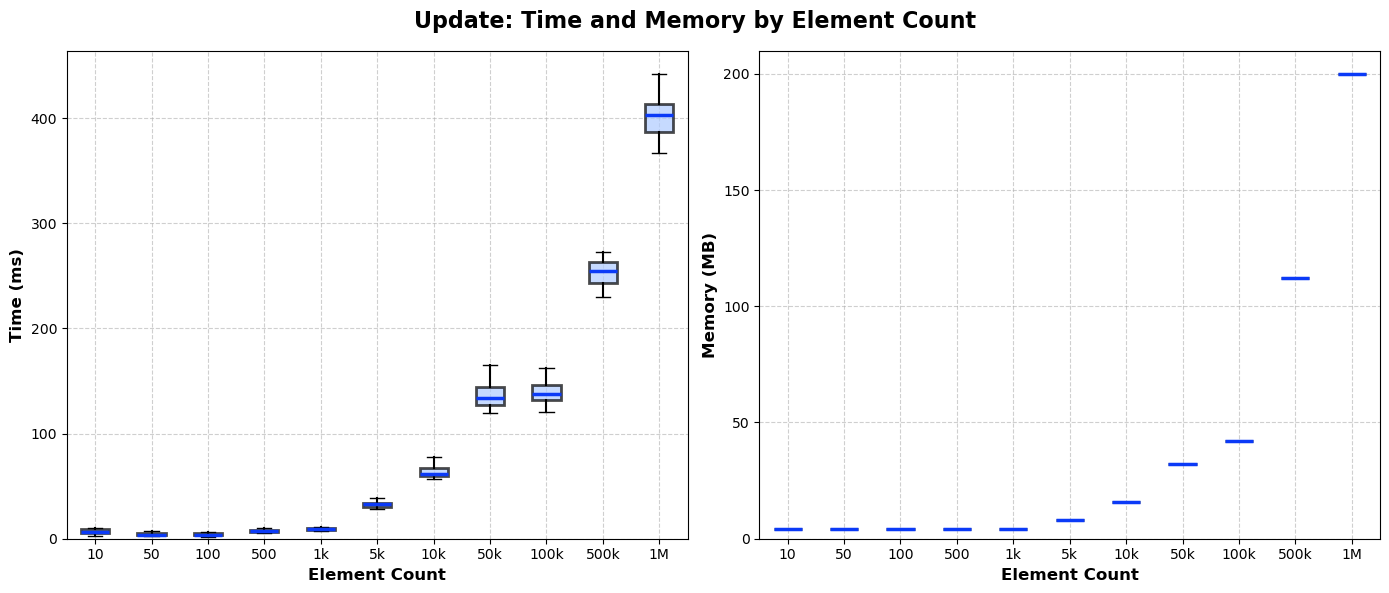

In [34]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

group_col = 'element_count'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))


update_runs.boxplot(column='time', by=group_col, ax=axes[0], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[0].set_title('')
axes[0].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.6)


update_runs.boxplot(column='mem', by=group_col, ax=axes[1], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[1].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[1].yaxis.set_major_locator(mticker.MultipleLocator(50*1024))  # 50 MB steps in MB 
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x/1024)}")) 
axes[1].set_ylabel('Memory (MB)', fontsize=12, fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('')
shorten_x_axis_labels(axes[0]) 
shorten_x_axis_labels(axes[1])
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)
plt.suptitle('Update: Time and Memory by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("img/rq2update.pdf", format='pdf', bbox_inches='tight') 
plt.show()

### Average

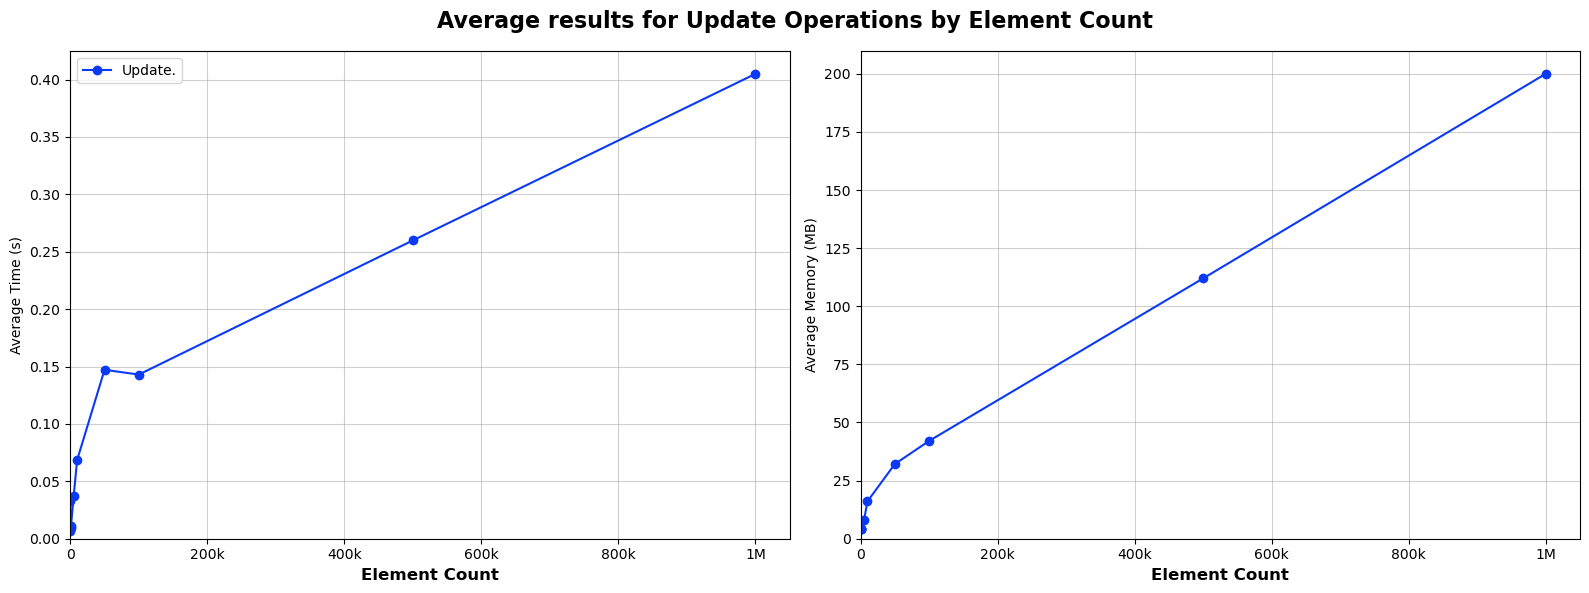

In [35]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


avg_r = update_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index() 

# Convert units: time ms -> s, memory KB -> MB
for df in [avg_r]:
    df['time'] = df['time'] / 1000       # ms to seconds
    df['mem'] = df['mem'] / 1024         # KB to MB

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Colors and markers for each dataset
datasets = [ 
    (avg_r, '#0B3AF7', 'o', 'Update.'),
]

# Plot average time
for df, color, marker, label in datasets:
    axes[0].plot(df['element_count'], df['time'], marker=marker, linestyle='-', color=color, label=label)
axes[0].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Average Time (s)')
axes[0].grid(True, alpha=0.6)
axes[0].xaxis.set_major_formatter(get_short_number_formatter())
axes[0].legend()

# Plot average memory
for df, color, marker, label in datasets:
    axes[1].plot(df['element_count'], df['mem'], marker=marker, linestyle='-', color=color, label=label)
axes[1].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Memory (MB)')
axes[1].grid(True, alpha=0.6)
axes[1].xaxis.set_major_formatter(get_short_number_formatter())
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)
axes[0].set_xlim(left=0)
axes[1].set_xlim(left=0)

plt.suptitle('Average results for Update Operations by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("img/rq2avgUpdate.pdf", format='pdf', bbox_inches='tight') 
plt.show()


## Delete Operations

### Delete Single

In [36]:
import pandas as pd
import glob

 
delete_s_run_files = glob.glob('../results/RQ2/DeleteSingle/DeleteSingle_run_*.csv')

# Load and concatenate all runs
delete_s_runs = pd.concat([pd.read_csv(f) for f in delete_s_run_files], ignore_index=True)

ordered_delete_s_runs = delete_s_runs.sort_values('time',ascending=False)

In [37]:
# Group by element count
group_col = 'element_count' 

grouped_delete_s_runs = delete_s_runs.groupby(group_col).agg(
    avg_time=('time', 'mean'),
    min_time=('time', 'min'),
    max_time=('time', 'max'),
    avg_mem=('mem', 'mean'),
    min_mem=('mem', 'min'),
    max_mem=('mem', 'max'),
).reset_index()

grouped_delete_s_runs

,element_count,avg_time,min_time,max_time,avg_mem,min_mem,max_mem
0,10,29.766667,6,148,4160.166667,4096,5965
1,50,19.033333,7,52,4099.300000,4098,4137
2,100,6.900000,4,10,4099.900000,4096,4161
3,500,20.966667,8,62,4106.200000,4098,4344
4,1000,11.733333,10,18,4113.933333,4096,4580
5,5000,60.866667,35,481,8200.966667,8192,8461
6,10000,59.066667,51,80,16470.900000,16384,18991
7,50000,309.000000,247,602,76001.300000,75778,80431
8,100000,602.566667,493,855,148866.500000,147456,154925
9,500000,2934.533333,2503,3725,448308.100000,124930,735234


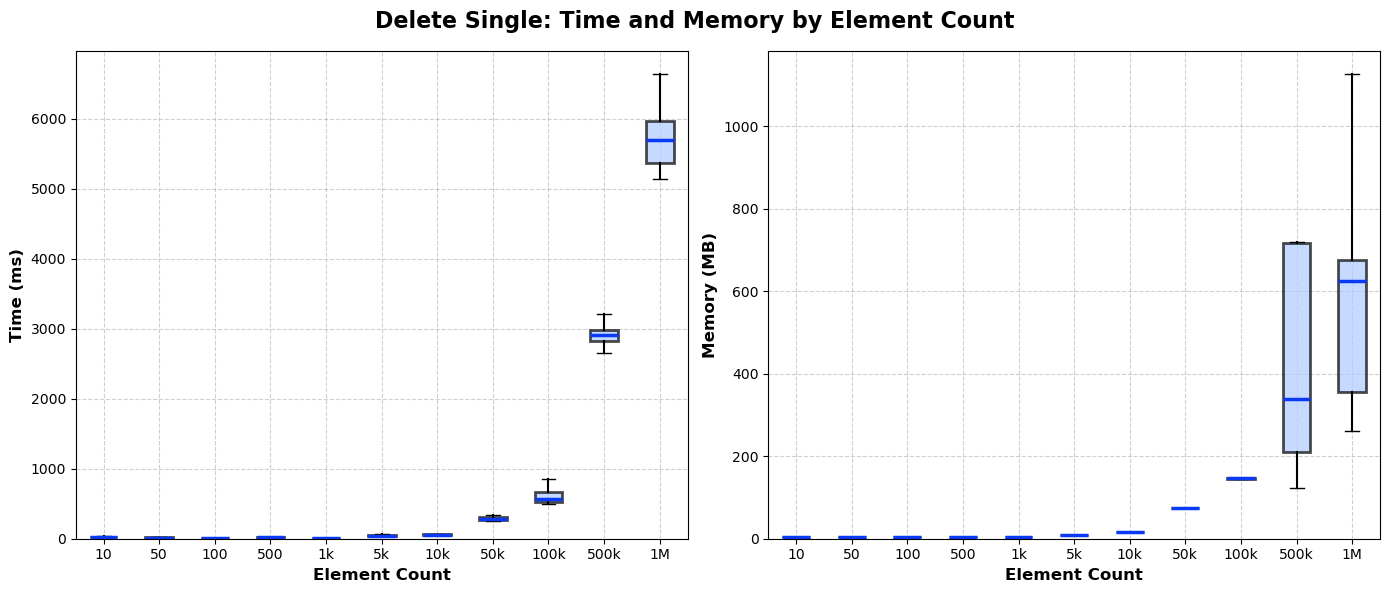

In [38]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

group_col = 'element_count'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))


delete_s_runs.boxplot(column='time', by=group_col, ax=axes[0], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[0].set_title('')
axes[0].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.6)


delete_s_runs.boxplot(column='mem', by=group_col, ax=axes[1], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[1].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[1].yaxis.set_major_locator(mticker.MultipleLocator(200*1024))  # 200 MB steps in MB 
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x/1024)}")) 
axes[1].set_ylabel('Memory (MB)', fontsize=12, fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('')
shorten_x_axis_labels(axes[0]) 
shorten_x_axis_labels(axes[1])
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)

plt.suptitle('Delete Single: Time and Memory by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("img/rq2deleteSingle.pdf", format='pdf', bbox_inches='tight') 
plt.show()

### Delete Containment Width

In [39]:
import pandas as pd
import glob

 
delete_c_w_run_files = glob.glob('../results/RQ2/DeleteContainmentWidth/DeleteContainmentWidth_run_*.csv')

# Load and concatenate all runs
delete_c_w_runs = pd.concat([pd.read_csv(f) for f in delete_c_w_run_files], ignore_index=True)

ordered_delete_c_w_runs = delete_c_w_runs.sort_values('time',ascending=False)

In [40]:
# Group by element count
group_col = 'element_count' 

grouped_delete_c_w_runs = delete_c_w_runs.groupby(group_col).agg(
    avg_time=('time', 'mean'),
    min_time=('time', 'min'),
    max_time=('time', 'max'),
    avg_mem=('mem', 'mean'),
    min_mem=('mem', 'min'),
    max_mem=('mem', 'max'),
).reset_index()

grouped_delete_c_w_runs

,element_count,avg_time,min_time,max_time,avg_mem,min_mem,max_mem
0,10,36.700000,9,196,4297.433333,3929,6149
1,50,27.900000,6,320,4298.166667,3957,6148
2,100,7.333333,5,13,4299.200000,3985,6149
3,500,26.166667,17,72,4300.033333,4012,6149
4,1000,16.466667,10,69,4368.466667,4012,6149
5,5000,57.600000,39,140,10242.000000,10242,10242
6,10000,97.233333,47,414,18843.200000,18434,20480
7,50000,315.000000,251,434,91956.733333,90112,94208
8,100000,580.566667,509,738,180291.166667,178178,182274
9,500000,2838.233333,2571,3353,542923.600000,174831,890882


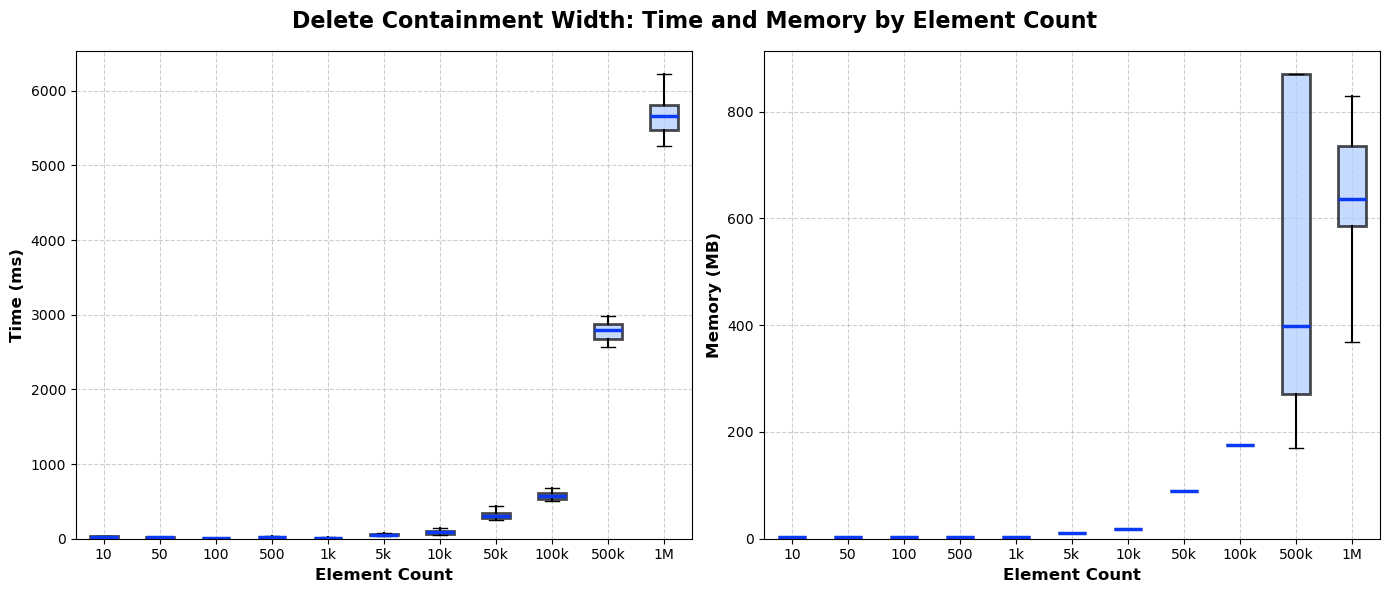

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

group_col = 'element_count'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))


delete_c_w_runs.boxplot(column='time', by=group_col, ax=axes[0], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[0].set_title('')
axes[0].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.6)


delete_c_w_runs.boxplot(column='mem', by=group_col, ax=axes[1], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[1].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[1].yaxis.set_major_locator(mticker.MultipleLocator(200*1024))  # 200 MB steps in MB 
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x/1024)}")) 
axes[1].set_ylabel('Memory (MB)', fontsize=12, fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('')
shorten_x_axis_labels(axes[0]) 
shorten_x_axis_labels(axes[1])
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)

plt.suptitle('Delete Containment Width: Time and Memory by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("img/rq2deleteCW.pdf", format='pdf', bbox_inches='tight') 
plt.show()

### Delete Containment Depth

In [42]:
import pandas as pd
import glob 
 
delete_c_d_run_files = glob.glob('../results/RQ2/DeleteContainmentDepth/DeleteContainmentDepth_run_*.csv') 
# Load and concatenate all runs
delete_c_d_runs = pd.concat([pd.read_csv(f) for f in delete_c_d_run_files], ignore_index=True) 
ordered_delete_c_d_runs = delete_c_d_runs.sort_values('time',ascending=False) 

In [43]:
# Group by element count
group_col = 'element_count' 

grouped_delete_c_d_runs = delete_c_d_runs.groupby(group_col).agg(
    avg_time=('time', 'mean'),
    min_time=('time', 'min'),
    max_time=('time', 'max'),
    avg_mem=('mem', 'mean'),
    min_mem=('mem', 'min'),
    max_mem=('mem', 'max'),
).reset_index()

grouped_delete_c_d_runs

,element_count,avg_time,min_time,max_time,avg_mem,min_mem,max_mem
0,10,13.200000,3,192,3721.666667,2331,4088
1,50,8.200000,3,66,3729.666667,2388,4087
2,100,7.666667,3,38,3727.900000,2265,4098
3,500,10.466667,2,46,3719.466667,1904,4098
4,1000,12.233333,3,41,3757.866667,3046,4098
5,5000,43.566667,2,150,6158.033333,3742,7645
6,10000,79.933333,63,208,11490.566667,9972,13769
7,50000,53.266667,2,258,8791.266667,3826,24458
8,100000,77.533333,3,168,11207.300000,2676,20480
9,500000,59.266667,3,215,8851.033333,3356,18434


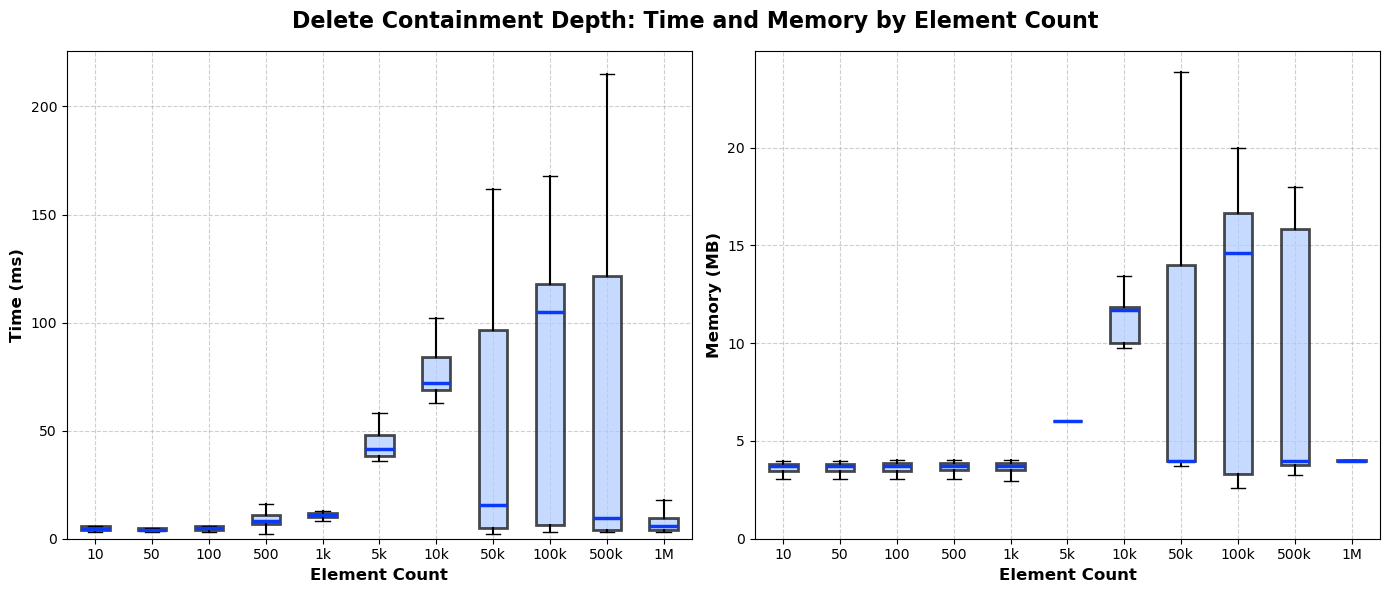

In [44]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

group_col = 'element_count' 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))


delete_c_d_runs.boxplot(column='time', by=group_col, ax=axes[0], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[0].set_title('')
axes[0].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.6)


delete_c_d_runs.boxplot(column='mem', by=group_col, ax=axes[1], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[1].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[1].yaxis.set_major_locator(mticker.MultipleLocator(5*1024))  # 5 MB steps in MB 
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x/1024)}")) 
axes[1].set_ylabel('Memory (MB)', fontsize=12, fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('')
shorten_x_axis_labels(axes[0]) 
shorten_x_axis_labels(axes[1])
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)

plt.suptitle('Delete Containment Depth: Time and Memory by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("img/rq2deleteCD.pdf", format='pdf', bbox_inches='tight') 
plt.show()

### Delete Cross Ref

In [45]:
import pandas as pd
import glob 
 
delete_c_r_run_files = glob.glob('../results/RQ2/DeleteCrossRef/DeleteCrossRef_run_*.csv') 
# Load and concatenate all runs
delete_c_r_runs = pd.concat([pd.read_csv(f) for f in delete_c_r_run_files], ignore_index=True) 
ordered_delete_c_r_runs = delete_c_r_runs.sort_values('time',ascending=False) 

In [46]:
# Group by element count
group_col = 'element_count' 

grouped_delete_d_r_runs = delete_c_r_runs.groupby(group_col).agg(
    avg_time=('time', 'mean'),
    min_time=('time', 'min'),
    max_time=('time', 'max'),
    avg_mem=('mem', 'mean'),
    min_mem=('mem', 'min'),
    max_mem=('mem', 'max'),
).reset_index()

grouped_delete_d_r_runs

,element_count,avg_time,min_time,max_time,avg_mem,min_mem,max_mem
0,10,35.600000,5,583,3763.466667,3321,4098
1,50,5.866667,3,36,3763.866667,3321,4098
2,100,6.633333,3,34,3764.933333,3321,4098
3,500,20.200000,13,49,3825.666667,3321,5491
4,1000,24.166667,13,74,3763.166667,3321,4098
5,5000,21.533333,16,73,3781.033333,3321,4098
6,10000,38.066667,31,124,3765.266667,3321,4098
7,50000,255.800000,223,537,5831.300000,5201,7142
8,100000,696.100000,638,1304,7863.566667,7419,8194
9,500000,12361.400000,12000,15959,30393.466667,29777,31502


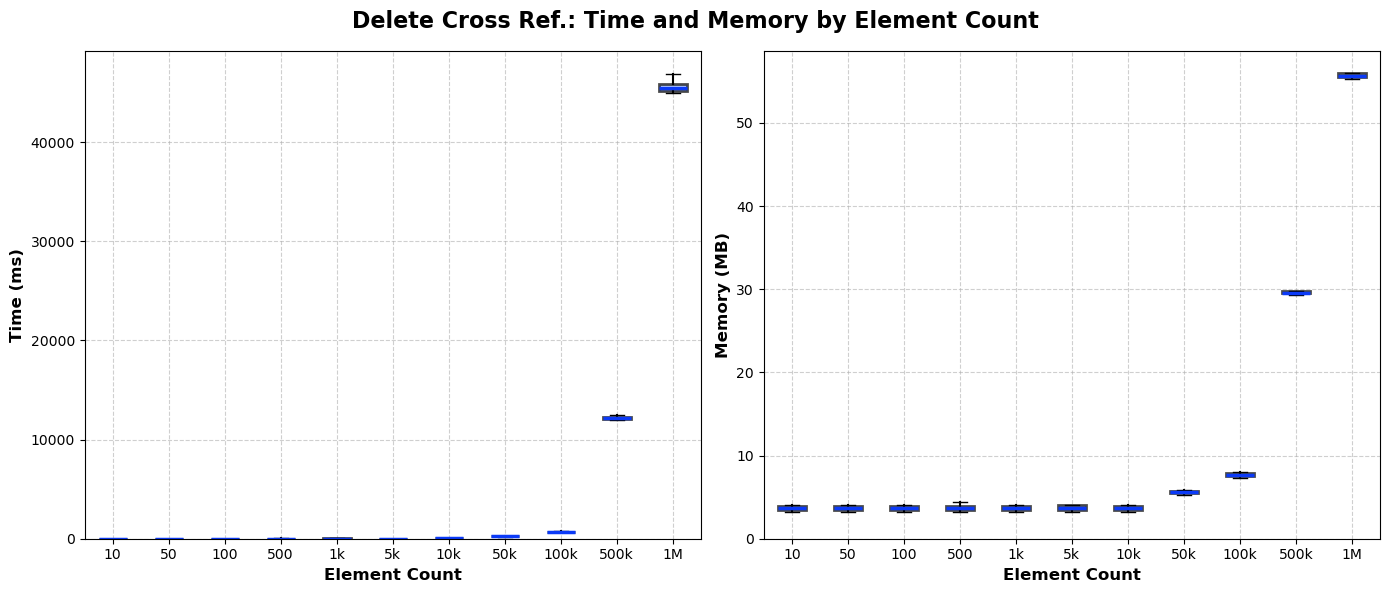

In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

group_col = 'element_count' 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))


delete_c_r_runs.boxplot(column='time', by=group_col, ax=axes[0], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))

axes[0].set_title('')
axes[0].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
axes[0].grid(True, linestyle='--', alpha=0.6)


delete_c_r_runs.boxplot(column='mem', by=group_col, ax=axes[1], patch_artist=True,showfliers=False, 
                   boxprops=dict(facecolor='#AFCBFF', color='black', linewidth=2, alpha=0.7),
                   medianprops=dict(color="#0B3AF7", linewidth=2.5),
                   whiskerprops=dict(color='black', linewidth=1.5))
axes[1].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[1].yaxis.set_major_locator(mticker.MultipleLocator(10*1024))  # 10 MB steps in MB 
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x/1024)}")) 
axes[1].set_ylabel('Memory (MB)', fontsize=12, fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_title('')
shorten_x_axis_labels(axes[0]) 
shorten_x_axis_labels(axes[1])
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)
plt.suptitle('Delete Cross Ref.: Time and Memory by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("img/rq2deleteCrossRef.pdf", format='pdf', bbox_inches='tight') 
plt.show()

### Average

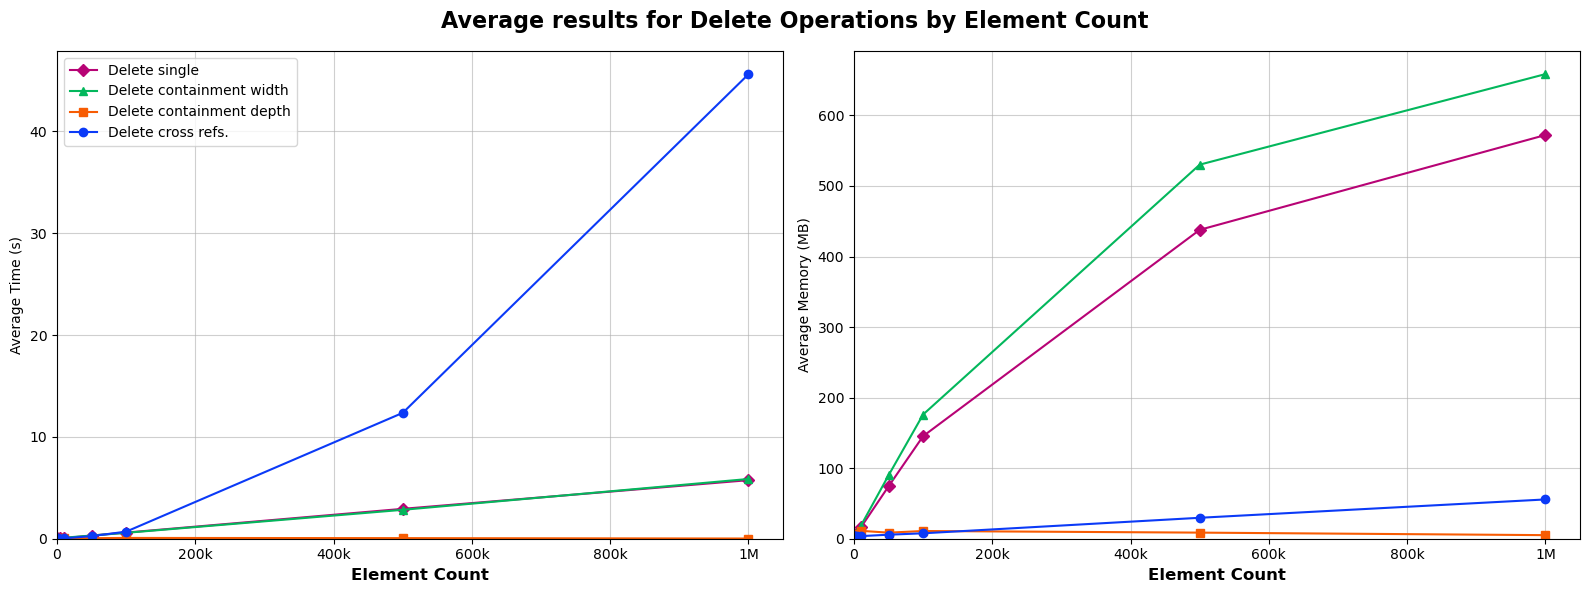

In [48]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


avg_r = delete_c_r_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
avg_d = delete_c_d_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
avg_w = delete_c_w_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
avg_s = delete_s_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()

# Convert units: time ms -> s, memory KB -> MB
for df in [avg_r, avg_d, avg_w, avg_s]:
    df['time'] = df['time'] / 1000       # ms to seconds
    df['mem'] = df['mem'] / 1024         # KB to MB

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Colors and markers for each dataset
datasets = [
    (avg_s, '#B70375', 'D', 'Delete single'),
    (avg_w, '#03B75C', '^', 'Delete containment width'),
    (avg_d, '#F75C03', 's', 'Delete containment depth'),
    (avg_r, '#0B3AF7', 'o', 'Delete cross refs.'),
]

# Plot average time
for df, color, marker, label in datasets:
    axes[0].plot(df['element_count'], df['time'], marker=marker, linestyle='-', color=color, label=label)
axes[0].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Average Time (s)')
axes[0].grid(True, alpha=0.6)
axes[0].xaxis.set_major_formatter(get_short_number_formatter())
axes[0].legend()

# Plot average memory
for df, color, marker, label in datasets:
    axes[1].plot(df['element_count'], df['mem'], marker=marker, linestyle='-', color=color, label=label)
axes[1].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Memory (MB)')
axes[1].grid(True, alpha=0.6)
axes[1].xaxis.set_major_formatter(get_short_number_formatter())
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)
axes[0].set_xlim(left=0)
axes[1].set_xlim(left=0)

plt.suptitle('Average results for Delete Operations by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("img/rq2avgDelete.pdf", format='pdf', bbox_inches='tight') 
plt.show()


## Shapiro-Wilk Test 

In [49]:
from scipy.stats import shapiro
# for time
statistic, p_value = shapiro(create_cross_ref_run['time'])
print(f"Shapiro-Wilk Test for Create Cross Ref. Time: Statistic={statistic}, p-value={p_value:.4f}")
statistic, p_value = shapiro(create_containment_d_runs['time'])
print(f"Shapiro-Wilk Test for Create Containment Depth Time: Statistic={statistic}, p-value={p_value:.4f}")
statistic, p_value = shapiro(create_containment_runs['time'])
print(f"Shapiro-Wilk Test for Create Containment Width Time: Statistic={statistic}, p-value={p_value:.4f}")
statistic, p_value = shapiro(create_runs['time'])
print(f"Shapiro-Wilk Test for Create Single Time: Statistic={statistic}, p-value={p_value:.4f}")

## for memory
statistic, p_value = shapiro(create_cross_ref_run['mem'])
print(f"Shapiro-Wilk Test for Create Cross Ref. Memory: Statistic={statistic}, p-value={p_value:.4f}")
statistic, p_value = shapiro(create_containment_d_runs['mem'])  
print(f"Shapiro-Wilk Test for Create Containment Depth Memory: Statistic={statistic}, p-value={p_value:.4f}")
statistic, p_value = shapiro(create_containment_runs['mem'])
print(f"Shapiro-Wilk Test for Create Containment Width Memory: Statistic={statistic}, p-value={p_value:.4f}")
statistic, p_value = shapiro(create_runs['mem'])
print(f"Shapiro-Wilk Test for Create Single Memory: Statistic={statistic}, p-value={p_value:.4f}")

Shapiro-Wilk Test for Create Cross Ref. Time: Statistic=0.5575838511838073, p-value=0.0000
Shapiro-Wilk Test for Create Containment Depth Time: Statistic=0.5196837260170468, p-value=0.0000
Shapiro-Wilk Test for Create Containment Width Time: Statistic=0.5560739588607357, p-value=0.0000
Shapiro-Wilk Test for Create Single Time: Statistic=0.5393974358110991, p-value=0.0000
Shapiro-Wilk Test for Create Cross Ref. Memory: Statistic=0.5815438139866504, p-value=0.0000
Shapiro-Wilk Test for Create Containment Depth Memory: Statistic=0.6224211487126282, p-value=0.0000
Shapiro-Wilk Test for Create Containment Width Memory: Statistic=0.6190512824064005, p-value=0.0000
Shapiro-Wilk Test for Create Single Memory: Statistic=0.648560245572479, p-value=0.0000


In [50]:
from scipy.stats import shapiro
# for time
statistic, p_value = shapiro(read_cross_ref_runs['time'])
print(f"Shapiro-Wilk Test for Read Cross Ref. Time: Statistic={statistic}, p-value={p_value:.4f}")
statistic, p_value = shapiro(read_c_d_runs['time'])
print(f"Shapiro-Wilk Test for Read Containment Depth Time: Statistic={statistic}, p-value={p_value:.4f}")
statistic, p_value = shapiro(read_c_w_runs['time'])
print(f"Shapiro-Wilk Test for Read Containment Width Time: Statistic={statistic}, p-value={p_value:.4f}")
statistic, p_value = shapiro(read_runs['time'])
print(f"Shapiro-Wilk Test for Read Single Time: Statistic={statistic}, p-value={p_value:.4f}")

## for memory
statistic, p_value = shapiro(read_cross_ref_runs['mem'])
print(f"Shapiro-Wilk Test for Read Cross Ref. Memory: Statistic={statistic}, p-value={p_value:.4f}")
statistic, p_value = shapiro(read_c_d_runs['mem'])  
print(f"Shapiro-Wilk Test for Read Containment Depth Memory: Statistic={statistic}, p-value={p_value:.4f}")
statistic, p_value = shapiro(read_c_w_runs['mem'])
print(f"Shapiro-Wilk Test for Read Containment Width Memory: Statistic={statistic}, p-value={p_value:.4f}")
statistic, p_value = shapiro(read_runs['mem'])
print(f"Shapiro-Wilk Test for Read Single Memory: Statistic={statistic}, p-value={p_value:.4f}")

Shapiro-Wilk Test for Read Cross Ref. Time: Statistic=0.10481818045415214, p-value=0.0000
Shapiro-Wilk Test for Read Containment Depth Time: Statistic=0.5399342338106866, p-value=0.0000
Shapiro-Wilk Test for Read Containment Width Time: Statistic=0.5338812086142448, p-value=0.0000
Shapiro-Wilk Test for Read Single Time: Statistic=0.3886430177367046, p-value=0.0000
Shapiro-Wilk Test for Read Cross Ref. Memory: Statistic=0.8525886350440628, p-value=0.0000
Shapiro-Wilk Test for Read Containment Depth Memory: Statistic=0.6136610610785285, p-value=0.0000
Shapiro-Wilk Test for Read Containment Width Memory: Statistic=0.5863255611899736, p-value=0.0000
Shapiro-Wilk Test for Read Single Memory: Statistic=0.14917355553464196, p-value=0.0000


In [51]:
from scipy.stats import shapiro
# for time
statistic, p_value = shapiro(update_runs['time'])
print(f"Shapiro-Wilk Test for Update Single Time: Statistic={statistic}, p-value={p_value:.4f}")

## for memory
statistic, p_value = shapiro(update_runs['mem'])
print(f"Shapiro-Wilk Test for Update Single Memory: Statistic={statistic}, p-value={p_value:.4f}")

Shapiro-Wilk Test for Update Single Time: Statistic=0.7733540694187, p-value=0.0000
Shapiro-Wilk Test for Update Single Memory: Statistic=0.6236054794336983, p-value=0.0000


In [52]:
from scipy.stats import shapiro

# For time
statistic, p_value = shapiro(delete_c_d_runs['time'])
print(f"Shapiro-Wilk Test for Delete Cross Ref. Time: Statistic={statistic:.4f}, p-value={p_value:.4f}")
statistic, p_value = shapiro(delete_c_d_runs['time'])
print(f"Shapiro-Wilk Test for Delete Containment Depth Time: Statistic={statistic:.4f}, p-value={p_value:.4f}")
statistic, p_value = shapiro(delete_c_w_runs['time'])
print(f"Shapiro-Wilk Test for Delete Containment Width Time: Statistic={statistic:.4f}, p-value={p_value:.4f}")
statistic, p_value = shapiro(delete_s_runs['time'])
print(f"Shapiro-Wilk Test for Delete Single Time: Statistic={statistic:.4f}, p-value={p_value:.4f}")

# For memory
statistic, p_value = shapiro(delete_c_r_runs['mem'])
print(f"Shapiro-Wilk Test for Delete Cross Ref. Memory: Statistic={statistic:.4f}, p-value={p_value:.4f}")
statistic, p_value = shapiro(delete_c_d_runs['mem'])
print(f"Shapiro-Wilk Test for Delete Containment Depth Memory: Statistic={statistic:.4f}, p-value={p_value:.4f}")
statistic, p_value = shapiro(delete_c_w_runs['mem'])
print(f"Shapiro-Wilk Test for Delete Containment Width Memory: Statistic={statistic:.4f}, p-value={p_value:.4f}")
statistic, p_value = shapiro(delete_s_runs['mem'])
print(f"Shapiro-Wilk Test for Delete Single Memory: Statistic={statistic:.4f}, p-value={p_value:.4f}")


Shapiro-Wilk Test for Delete Cross Ref. Time: Statistic=0.7093, p-value=0.0000
Shapiro-Wilk Test for Delete Containment Depth Time: Statistic=0.7093, p-value=0.0000
Shapiro-Wilk Test for Delete Containment Width Time: Statistic=0.5560, p-value=0.0000
Shapiro-Wilk Test for Delete Single Time: Statistic=0.5584, p-value=0.0000
Shapiro-Wilk Test for Delete Cross Ref. Memory: Statistic=0.5355, p-value=0.0000
Shapiro-Wilk Test for Delete Containment Depth Memory: Statistic=0.6599, p-value=0.0000
Shapiro-Wilk Test for Delete Containment Width Memory: Statistic=0.5963, p-value=0.0000
Shapiro-Wilk Test for Delete Single Memory: Statistic=0.5776, p-value=0.0000


## Results Summary

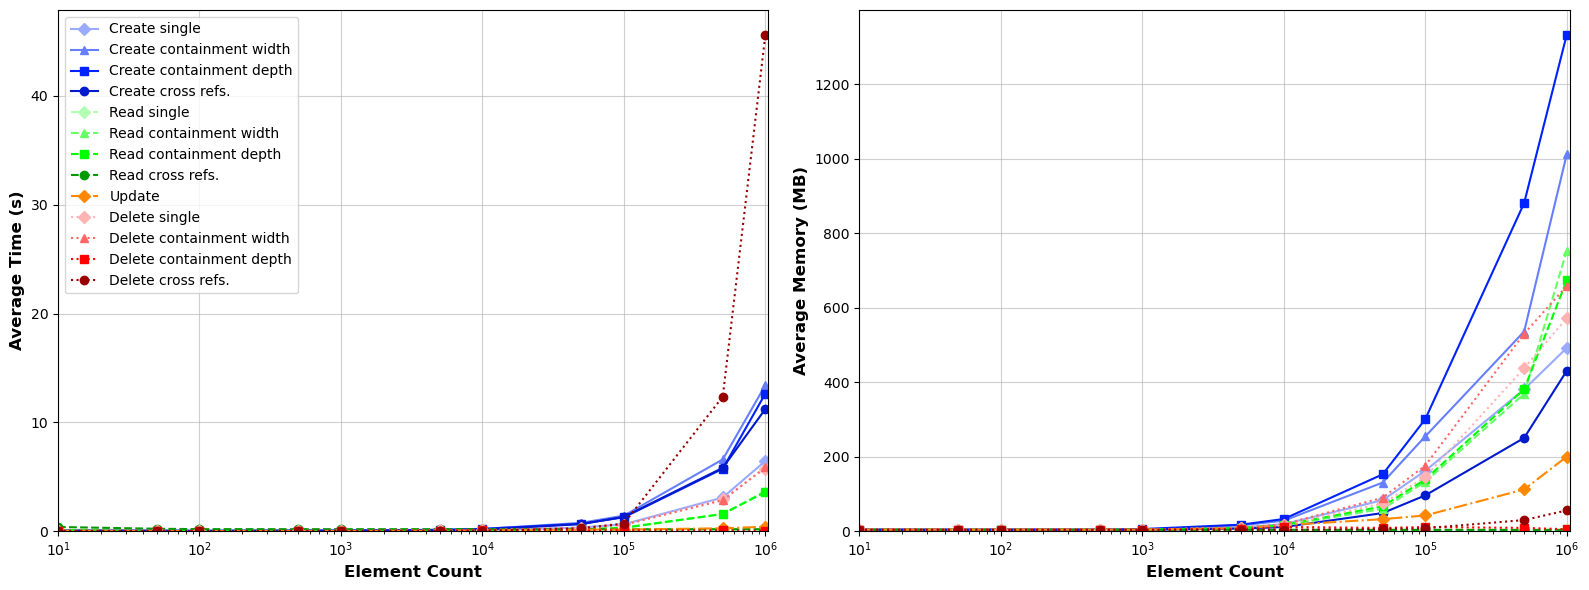

In [53]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Compute averages for all dataframes
c_avg_r = create_cross_ref_run.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
c_avg_d = create_containment_d_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
c_avg_w = create_containment_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
c_avg_s = create_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()

r_avg_r = read_cross_ref_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
r_avg_d = read_c_d_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
r_avg_w = read_c_w_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
r_avg_s = read_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()

u_avg = update_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()

d_avg_r = delete_c_r_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
d_avg_d = delete_c_d_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
d_avg_w = delete_c_w_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
d_avg_s = delete_s_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()

# Convert units: time ms -> s, memory KB -> MB
for df in [c_avg_r, c_avg_d, c_avg_w, c_avg_s, r_avg_r, r_avg_d, r_avg_w, r_avg_s,u_avg, d_avg_r, d_avg_d, d_avg_w, d_avg_s]:
    df['time'] = df['time'] / 1000       # ms to seconds
    df['mem'] = df['mem'] / 1024         # KB to MB

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

datasets = [
    # CREATE
    (c_avg_s, "#99AAFF", 'D', '-', 'Create single'),
    (c_avg_w, "#667FFF", '^', '-', 'Create containment width'),
    (c_avg_d, '#0022FF', 's', '-', 'Create containment depth'),
    (c_avg_r, '#001ACC', 'o', '-', 'Create cross refs.'),

    # READ
    (r_avg_s, '#B3FFB3', 'D', '--', 'Read single'),
    (r_avg_w, '#66FF66', '^', '--', 'Read containment width'),
    (r_avg_d, '#00FF00', 's', '--', 'Read containment depth'),
    (r_avg_r, '#009900', 'o', '--', 'Read cross refs.'),

    # UPDATE
    (u_avg, "#FF8800", 'D', '-.', 'Update'),

    # DELETE
    (d_avg_s, '#FFB3B3', 'D', ':', 'Delete single'),
    (d_avg_w, '#FF6666', '^', ':', 'Delete containment width'),
    (d_avg_d, '#FF0000', 's', ':', 'Delete containment depth'),
    (d_avg_r, '#990000', 'o', ':', 'Delete cross refs.'),
]


# Plot average time
for df, color, marker, linestyle, label in datasets:
    axes[0].plot(df['element_count'], df['time'],
                 marker=marker, linestyle=linestyle, color=color, label=label)


axes[0].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Average Time (s)',fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.6)
axes[0].xaxis.set_major_formatter(get_short_number_formatter())
axes[0].legend()

# Plot average memory
for df, color, marker, linestyle, label in datasets:
    axes[1].plot(df['element_count'], df['mem'],
                 marker=marker, linestyle=linestyle, color=color, label=label)
axes[1].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Memory (MB)',fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.6)
axes[1].xaxis.set_major_formatter(get_short_number_formatter())
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)
axes[0].set_xlim(left=0)
axes[1].set_xlim(left=0)
axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[0].set_xlim(left=min(df['element_count'].min() for df,_,_,_,_ in datasets))
axes[1].set_xlim(left=min(df['element_count'].min() for df,_,_,_,_ in datasets))

# plt.suptitle('Average results for CRUD Operations by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("img/rq2avg.pdf", format='pdf', bbox_inches='tight') 
plt.show()


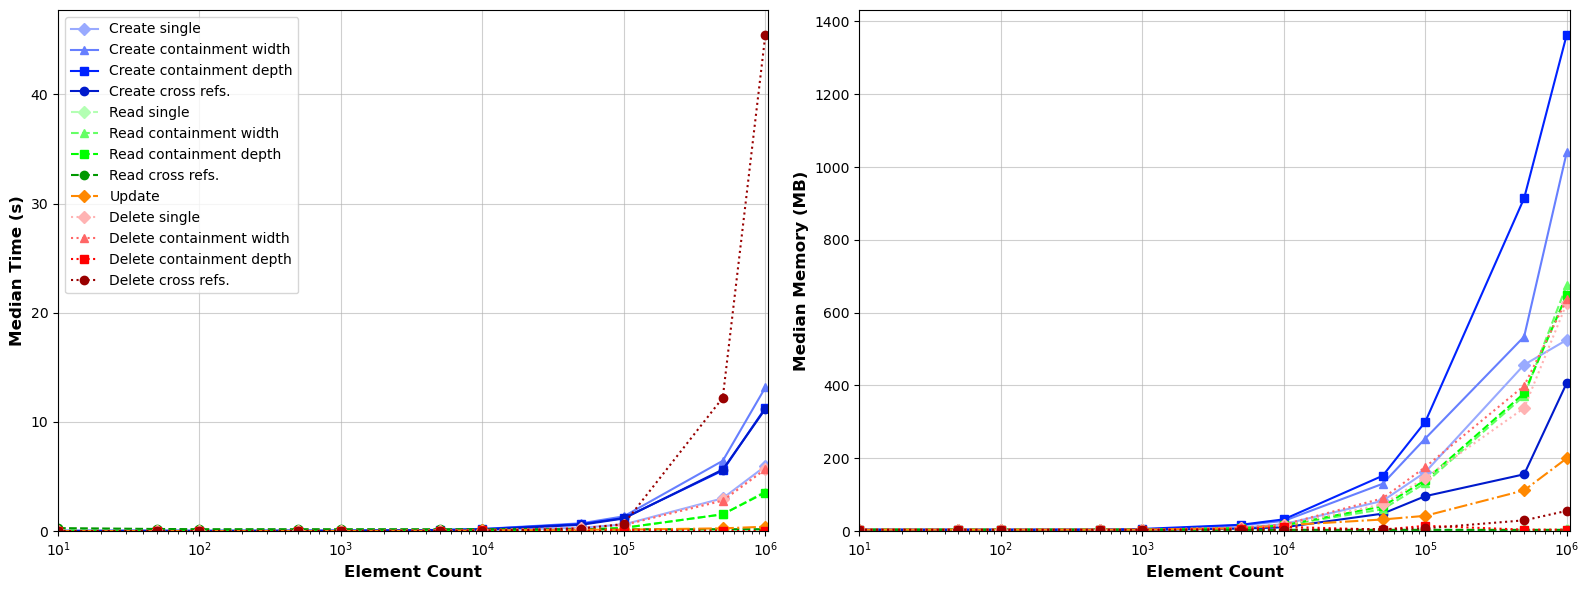

In [54]:
import matplotlib.pyplot as plt

# Compute median for all dataframes
c_avg_r = create_cross_ref_run.groupby('element_count').agg({'time':'median', 'mem':'median'}).reset_index()
c_avg_d = create_containment_d_runs.groupby('element_count').agg({'time':'median', 'mem':'median'}).reset_index()
c_avg_w = create_containment_runs.groupby('element_count').agg({'time':'median', 'mem':'median'}).reset_index()
c_avg_s = create_runs.groupby('element_count').agg({'time':'median', 'mem':'median'}).reset_index()

r_avg_r = read_cross_ref_runs.groupby('element_count').agg({'time':'median', 'mem':'median'}).reset_index()
r_avg_d = read_c_d_runs.groupby('element_count').agg({'time':'median', 'mem':'median'}).reset_index()
r_avg_w = read_c_w_runs.groupby('element_count').agg({'time':'median', 'mem':'median'}).reset_index()
r_avg_s = read_runs.groupby('element_count').agg({'time':'median', 'mem':'median'}).reset_index()

u_avg = update_runs.groupby('element_count').agg({'time':'median', 'mem':'median'}).reset_index()

d_avg_r = delete_c_r_runs.groupby('element_count').agg({'time':'median', 'mem':'median'}).reset_index()
d_avg_d = delete_c_d_runs.groupby('element_count').agg({'time':'median', 'mem':'median'}).reset_index()
d_avg_w = delete_c_w_runs.groupby('element_count').agg({'time':'median', 'mem':'median'}).reset_index()
d_avg_s = delete_s_runs.groupby('element_count').agg({'time':'median', 'mem':'median'}).reset_index()

# Convert units: time ms -> s, memory KB -> MB
for df in [c_avg_r, c_avg_d, c_avg_w, c_avg_s, r_avg_r, r_avg_d, r_avg_w, r_avg_s,u_avg, d_avg_r, d_avg_d, d_avg_w, d_avg_s]:
    df['time'] = df['time'] / 1000       # ms to seconds
    df['mem'] = df['mem'] / 1024         # KB to MB

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

datasets = [
    # CREATE
    (c_avg_s, "#99AAFF", 'D', '-', 'Create single'),
    (c_avg_w, "#667FFF", '^', '-', 'Create containment width'),
    (c_avg_d, '#0022FF', 's', '-', 'Create containment depth'),
    (c_avg_r, '#001ACC', 'o', '-', 'Create cross refs.'),

    # READ
    (r_avg_s, '#B3FFB3', 'D', '--', 'Read single'),
    (r_avg_w, '#66FF66', '^', '--', 'Read containment width'),
    (r_avg_d, '#00FF00', 's', '--', 'Read containment depth'),
    (r_avg_r, '#009900', 'o', '--', 'Read cross refs.'),

    # UPDATE
    (u_avg, "#FF8800", 'D', '-.', 'Update'),

    # DELETE
    (d_avg_s, '#FFB3B3', 'D', ':', 'Delete single'),
    (d_avg_w, '#FF6666', '^', ':', 'Delete containment width'),
    (d_avg_d, '#FF0000', 's', ':', 'Delete containment depth'),
    (d_avg_r, '#990000', 'o', ':', 'Delete cross refs.'),
]


# Plot average time
for df, color, marker, linestyle, label in datasets:
    axes[0].plot(df['element_count'], df['time'],
                 marker=marker, linestyle=linestyle, color=color, label=label)


axes[0].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Median Time (s)',fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.6)
axes[0].xaxis.set_major_formatter(get_short_number_formatter())
axes[0].legend()

# Plot average memory
for df, color, marker, linestyle, label in datasets:
    axes[1].plot(df['element_count'], df['mem'],
                 marker=marker, linestyle=linestyle, color=color, label=label)
axes[1].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Median Memory (MB)',fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.6)
axes[1].xaxis.set_major_formatter(get_short_number_formatter())
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)
axes[0].set_xlim(left=0)
axes[1].set_xlim(left=0)
axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[0].set_xlim(left=min(df['element_count'].min() for df,_,_,_,_ in datasets))
axes[1].set_xlim(left=min(df['element_count'].min() for df,_,_,_,_ in datasets))

# plt.suptitle('Median results for CRUD Operations by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("img/rq2med.pdf", format='pdf', bbox_inches='tight') 
plt.show()


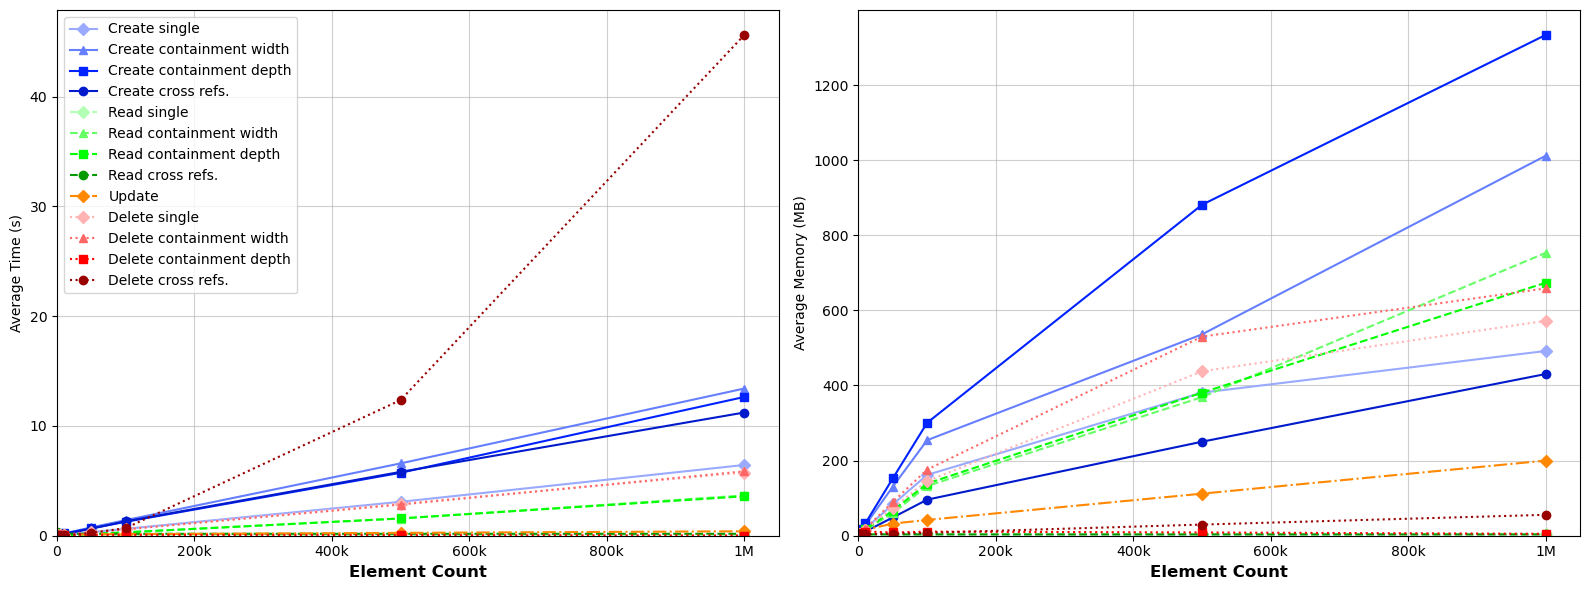

In [55]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


c_avg_r = create_cross_ref_run.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
c_avg_d = create_containment_d_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
c_avg_w = create_containment_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
c_avg_s = create_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()

r_avg_r = read_cross_ref_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
r_avg_d = read_c_d_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
r_avg_w = read_c_w_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
r_avg_s = read_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()

u_avg = update_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()

d_avg_r = delete_c_r_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
d_avg_d = delete_c_d_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
d_avg_w = delete_c_w_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()
d_avg_s = delete_s_runs.groupby('element_count').agg({'time':'mean', 'mem':'mean'}).reset_index()

# Convert units: time ms -> s, memory KB -> MB
for df in [c_avg_r, c_avg_d, c_avg_w, c_avg_s, r_avg_r, r_avg_d, r_avg_w, r_avg_s,u_avg, d_avg_r, d_avg_d, d_avg_w, d_avg_s]:
    df['time'] = df['time'] / 1000       # ms to seconds
    df['mem'] = df['mem'] / 1024         # KB to MB

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

datasets = [
    # CREATE
    (c_avg_s, "#99AAFF", 'D', '-', 'Create single'),
    (c_avg_w, "#667FFF", '^', '-', 'Create containment width'),
    (c_avg_d, '#0022FF', 's', '-', 'Create containment depth'),
    (c_avg_r, '#001ACC', 'o', '-', 'Create cross refs.'),

    # READ
    (r_avg_s, '#B3FFB3', 'D', '--', 'Read single'),
    (r_avg_w, '#66FF66', '^', '--', 'Read containment width'),
    (r_avg_d, '#00FF00', 's', '--', 'Read containment depth'),
    (r_avg_r, '#009900', 'o', '--', 'Read cross refs.'),

    # UPDATE
    (u_avg, "#FF8800", 'D', '-.', 'Update'),

    # DELETE
    (d_avg_s, '#FFB3B3', 'D', ':', 'Delete single'),
    (d_avg_w, '#FF6666', '^', ':', 'Delete containment width'),
    (d_avg_d, '#FF0000', 's', ':', 'Delete containment depth'),
    (d_avg_r, '#990000', 'o', ':', 'Delete cross refs.'),
]


# Plot average time
for df, color, marker, linestyle, label in datasets:
    axes[0].plot(df['element_count'], df['time'],
                 marker=marker, linestyle=linestyle, color=color, label=label)


axes[0].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Average Time (s)')
axes[0].grid(True, alpha=0.6)
axes[0].xaxis.set_major_formatter(get_short_number_formatter())
axes[0].legend()

# Plot average memory
for df, color, marker, linestyle, label in datasets:
    axes[1].plot(df['element_count'], df['mem'],
                 marker=marker, linestyle=linestyle, color=color, label=label)
axes[1].set_xlabel('Element Count', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Memory (MB)')
axes[1].grid(True, alpha=0.6)
axes[1].xaxis.set_major_formatter(get_short_number_formatter())
axes[0].set_ylim(bottom=0)
axes[1].set_ylim(bottom=0)
axes[0].set_xlim(left=0)
axes[1].set_xlim(left=0)

# plt.suptitle('Average results for CRUD Operations by Element Count', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig("img/rq2avgfull.pdf", format='pdf', bbox_inches='tight') 
plt.show()
